<a href="https://colab.research.google.com/github/DavideBuldrin1/feature-extraction-for-text/blob/test-bert/lsa_lda_and_nmf_for_feature_extraction_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSA LDA and NMF for text mining

In the notebook we will focus on three methods for dimensionality reduction (feature extraction) and topic modelling.
- **Latent Semantic Analysis (LSA)**
- **Latent Dirichlet Allocation (LDA)**
- **Non-Negative Matrix Factorization (NMF)**

# Introduction to the methods
##  Latent Semantic Analysis (LSA)
LSA assumes that words that are close in meaning will occur in similar pieces of text (distributional hypothesis). A matrix containing word counts or (tf-idf values) per document  is constructed than singular value decomposition (SVD) is used to reduce the number of rows while preserving similarity structure among columns. document can be compared by cosine similarity.

**PRO**
- Dimension Reduction: LSA effectively reduces dimensionality of data while capturing semantic relationships, making it useful for information retrieval and document similarity.
- Visualization: first dimensions of the reduction contain a lot of information and useful 2D or 3D can but used to visualize similarities
- Mathematically Sound: LSA is based on well-established linear algebra techniques, which can be advantageous for certain applications.
- Fast

**Cons**
- Interpretability:results not easy interpretable (also due to the fact that we can have negative values)


**NOTE** SVD is the usual $ M = U \sum{}V$*  U and V complex unitary matrix on a orthonormal eigenbasis that represents a rotation, than $\sum{}$ is the diagonal matrix of eigenvector that represent the dilation,
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Singular-Value-Decomposition.svg/1024px-Singular-Value-Decomposition.svg.png" width="500"/>
</div>

##  Latent Dirichlet Allocation (LDA)
Key characteristic: LDA is a generative probabilistic model that represents documents as mixtures of topics, making it useful for document clustering and topic modelling.
A topic is considered to be a set of terms that, taken together, suggest a shared theme. LDA tries to uncover these latent (hidden) topics by analyzing the distribution of words in the documents.
LDA assigns a probability distribution of topics to each document and a probability distribution of words to each topic. These probability distributions can be used as features

Most documents will contain only a relatively small number of topics. In the collection individual topics will occur with differing frequencies. That is, they have a probability distribution, so that a given document is more likely to contain some topics than others.
Within a topic, certain terms will be used much more frequently than others. In other words, terms within a topic will also have their own probability distribution.

The probability are computed using Bayesian methods and an Expectation Maximization algorithm.

**How does LDA work?**

We know the words that belong to a document we need to calculate probability of words belonging into a topic.

- Initially for each document each word in each document randomly assigned to one of k topics (k is chosen beforehand).
•	For each document d, go through each word w and compute :
  1.	**p(topic t | document d)**: the proportion of words in document d that are assigned to topic t. Tries to capture how many words belong to the topic t for a given document d. Excluding the current word.
If a lot of words from d belongs to t, it is more probable that word w belongs to t.
( #words in d with t +alpha/ #words in d with any topic+ k*alpha)
  2.	**p(word w| topic t)**: probability of observing a specific word (w) given a particular topic.
LDA represents documents as a mixture of topics. Similarly, a topic is a mixture of words. If a word has high probability of being in a topic, all the documents having w will be more strongly associated with t as well. Similarly, if w is not very probable to be in t it won’t be bringing many such documents to t.
  3.	Update the probability for word w belonging to topic t, as:
  **p(word w with topic t)** = **p(topic t | document d)** x **p(word w | topic t)**


**PRO**
- Topic Proportions: LDA provides topic proportions for each document, allowing you to understand the mixture of topics in a document.
- Multiclass classification: for the reason above it can be use for more complex classification tasks. (the topic may not correspond to a class the topic extraction is not supervised)
- Interpretability : Probability distribution and topics
- Polysemy: a single word can be important for more than one topic

**Cons**
- Parameter tuning
- Slower than other methods
- Visualization: not easily adaptable for visualization purpose

Is it possible maybe to create our topic assigning prob to word while in LSA is not straight forward to which word give negative or near zero values because it is not creating topic it is reducing dimension.


##  Non-Negative Matrix Factorization (NMF)
In Non Negative matrix Factorization a matrix **V** is factorized in the product of two matrix **W** **H** (i.e. **V = WH**) none of the matrix has negative elements this is not guaranteed to be possible and usually achieved by numerical approximation.
The dimensionality can be significantly reduced if **V** is an *m × n* matrix, **W** is an *m × p* matrix, and **H** is a *p × n* and **p** can be **small** the product **HW** should be similar to **V** minimizing Frobenius norm and enforcing the fact that the values have to be non negative.
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png" width="500"/>
</div>

**PRO**
- Dimension Reduction
- Interpretability: positive values make easy to identify the extracted topic by looking at words with the bigger values inside the topic
- Usually fast

**Cons**
- Visualization: not easily adaptable for visualization purpose (each dimension represent a topic if a lot of them are useful is no easy to plot them in 2D or 3D graphs)

The output of this last model looks like the output of LDA we have topics and only positive values but is obtained without using probability distribution (at least not explicitly the distribution of words have an impact) and bayesian model.

# In This Notebook

- **LSA, LDA, NMF** will be performed in a subset of the *fetch_20newsgroups*
 <font color='blue'>12487 text documents</font> divided in <font color='blue'>13 classes </font> referring to <font color='blue'>5 bigger classes</font> (computer, motors, sports, science, politics),
- **Visualization** on low dimensional spaces
- **Supervised Classification** for an objective evaluation
- **Interpretability of features**
- **Time and Classification score** with different number of extracted feature.
- **Comparison with Language models**


## Utils and import packages

This section Contains functions to visualize and useful dictionaries containing classes ids.

In [1]:
!pip install tensorflow tensorflow-hub
#!pip install umap-learn
!pip install transformers evaluate datasets
!pip install lbl2vec

In [2]:
from huggingface_hub import notebook_login

import evaluate
import random
from datasets import Dataset, DatasetDict
from huggingface_hub import notebook_login
from transformers import DataCollatorWithPadding, AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, create_optimizer, TFAutoModelForSequenceClassification
from transformers.keras_callbacks import KerasMetricCallback

In [3]:
import torch
import nltk
import time
# import umap
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np # linear algebra
import pandas as pd # data processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy import stats
from tqdm import tqdm
from scipy.io import arff
from lbl2vec import Lbl2Vec
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score,  adjusted_rand_score, normalized_mutual_info_score, pairwise_distances
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 42

# Get the list of stopwords
nltk.download('stopwords')
stop_words = list(stopwords.words('english')) + ['just', 'don', 'like', 'think', 've', 'good', 'time', 'say', 'really', 'll']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
def plot_lsa_2d(lsa_results, labels, component1=0, component2=1):
    """
    Plot LSA results in 2D using two components and color points based on labels.

    Args:
        lsa_results: The LSA results
        labels: Labels for each data point
        component1 (int): Index of the first component to plot (default: 0)
        component2 (int): Index of the second component to plot (default: 1)
    """
    rgb_colors = ['#669999', '#b3cccc', '#334d4d','#ff0000','#ff9999', '#3366ff','#00ccff','#00cc00','#70db70','#00ff00','#ffd24d','#e6e600','#ffcc66']

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=lsa_results[:, component1], y=lsa_results[:, component2], hue=labels, palette=rgb_colors, s=80, legend='full') #palette = 'viridis'

    x = min(lsa_results[:, component1])*2
    y = max(lsa_results[:, component2])*0.9

    # Add labels and a legend
    plt.xlabel(f'Component {component1 + 1}')
    plt.ylabel(f'Component {component2 + 1}')
    plt.title('Results in 2D')
    plt.legend(title='Labels')
    plt.text(x, y, ' gray = computer \n red= vehicles \n blue = sport\n green = science \n yellow = politics', fontsize=10, color='black')

    # Show the plot
    plt.show()

def visualize_features(nmf_results, class_labels,categories):
    """
    Visualize the distribution of NMF or LDA features for each class.

    Args:
        nmf_results : The NMF results
        class_labels: Labels for each data point.
    """
    unique_classes = np.sort(np.unique(class_labels))
    # Create a figure with subplots for each class
    fig, axes = plt.subplots(len(unique_classes), figsize=(10, 30))
    fig.subplots_adjust(hspace=0.5)

    for i, class_label in enumerate(unique_classes):
        # Filter data points for the current class
        class_indices = np.where(class_labels == class_label)[0]
        class_data = nmf_results[class_indices]

        feature_mean =[]
        for j in range(len(categories)):
                feature_mean.append(class_data[:, j].mean())
        # Create a histogram for each class
        axes[i].bar(np.arange(len(feature_mean)), feature_mean,)
        axes[i].set_title(f'{categories[i]}')
        axes[i].set_xlabel('feature')
        axes[i].set_ylabel('mean')

    plt.show()

# set of list and dict containg useful infor for classes
categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    #"soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    #"talk.religion.misc",
]

rgb_colors = ['#669999', '#b3cccc', '#334d4d','#ff0000','#ff9999', '#3366ff','#00ccff','#00cc00','#70db70','#00ff00','#ffd24d','#e6e600','#ffcc66']
categories = [
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",

    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",

]
colors = ['#669999', '#334d4d', '#00ccff','#00ff00','#ffcc66']
dict_related_categories = {0:0,1:0,2:0, 3:1,4:1, 5:2,6:2, 7:3,8:3,9:3, 10:4,11:4,12:4} # similar topic aggegated
dict_related_categories_name = {"comp.graphics":0, "comp.sys.ibm.pc.hardware":0, "comp.sys.mac.hardware":0,
                                "rec.autos":1,"rec.motorcycles":1,
                                "rec.sport.baseball":2,"rec.sport.hockey":2,
                                "sci.crypt":3,"sci.electronics":3,"sci.med":3,
                                "talk.politics.guns":4,"talk.politics.mideast":4,"talk.politics.misc":4}
id2label = {"comp.graphics":0, "comp.sys.ibm.pc.hardware":1, "comp.sys.mac.hardware":2,
                                "rec.autos":3,"rec.motorcycles":4,
                                "rec.sport.baseball":5,"rec.sport.hockey":6,
                                "sci.crypt":7,"sci.electronics":8,"sci.med":9,
                                "talk.politics.guns":10,"talk.politics.mideast":11,"talk.politics.misc":12}
label2id = {v: k for k, v in id2label.items()}

max_width = max(len(f'{label2id[i]} :') for i in range(13))


def annotate_cm(cm):
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black')



def evaluator(extracted_features, labels, dict_related_categories, categories,random_state = 42, related_categories = None):
    '''takes feature and hierachcak structure of label and performs a classifcation on
       using a random forest presenting the results
    '''
    x_train_split, x_test_split, label_train, labels_test = train_test_split(
    extracted_features, labels, test_size=0.3, random_state=random_state)
    rf = RandomForestClassifier(criterion  = 'gini').fit(x_train_split, label_train)
    predictions = rf.predict(x_test_split)
    cm = ((confusion_matrix(labels_test, predictions,normalize = 'true'))*100).round(0)
    cm = np.vectorize(lambda x: int(f'{x:.0f}'))(cm)
    cm_similar_topic = ((confusion_matrix([dict_related_categories[i] for i in labels_test], [dict_related_categories[i] for i in predictions],normalize = 'true'))*100).round()
    cm_similar_topic = np.vectorize(lambda x: int(f'{x:.0f}'))(cm_similar_topic)

    report1 = classification_report(labels_test, predictions, target_names=categories)
    report2 = classification_report([dict_related_categories[i] for i in labels_test], [dict_related_categories[i] for i in predictions], target_names=related_categories)

    # plot classification results and feature importance
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 2, 1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges,origin='upper', aspect='auto',)
    plt.title('all topics')
    plt.colorbar()
    plt.xticks(np.arange(len(cm)))
    plt.yticks(np.arange(len(cm)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    annotate_cm(cm)

    plt.subplot(3, 2, 3)
    plt.text(0.2, 0.2, report1, horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off')

    # Plot confusion matrix 2
    plt.subplot(3, 2, 2)
    plt.imshow(cm_similar_topic, interpolation='nearest', cmap=plt.cm.Oranges,origin='upper', aspect='auto', )
    plt.title('similar topics aggregated')
    plt.colorbar()
    plt.xticks(np.arange(len(cm_similar_topic)))
    plt.yticks(np.arange(len(cm_similar_topic)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    annotate_cm(cm_similar_topic)

    plt.subplot(3, 2, 4)
    plt.text(0.2, 0.2, report2, horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off')

    plt.subplot(3, 2, 5)
    plt.barh(range(len(extracted_features[0])), rf.feature_importances_)
    plt.yticks(np.arange(len(extracted_features[0])))
    plt.title('Feature importance')

    plt.tight_layout()
    plt.show()

def run_test(num_topics, tfidf_matrix, count_matrix,  labels):
    ''' creates classification scores for NMF LDA LSA '''

    start = time.time()
    lsa = TruncatedSVD(n_components=num_topics)
    lsa_result = lsa.fit_transform(tfidf_matrix)
    end = time.time()
    time_lsa = (end-start)

    x_train_split, x_test_split, label_train, label_test = train_test_split(
    lsa_result, labels, test_size=0.3, random_state=random_state)
    rf = RandomForestClassifier(criterion  = 'gini').fit(x_train_split, label_train)
    predictions = rf.predict(x_test_split)
    lsa_score = f1_score(label_test, predictions, average = 'macro')

    # Apply LDA
    start = time.time()
    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online', random_state=random_state) # max_iter and learning online are usefull to make the computation faster learning_offset=50.
    lda_result = lda.fit_transform(count_matrix)
    end = time.time()
    time_lda = (end-start)
    x_train_split, x_test_split, label_train, label_test = train_test_split(
    lda_result, labels, test_size=0.3, random_state=random_state)
    rf = RandomForestClassifier(criterion  = 'gini').fit(x_train_split, label_train)
    predictions = rf.predict(x_test_split)
    lda_score = f1_score(label_test, predictions, average = 'macro')

    # Apply NMF
    start = time.time()
    nmf = NMF(n_components=num_topics, random_state=random_state, l1_ratio=.5)
    nmf_result = nmf.fit_transform(tfidf_matrix)
    end = time.time()
    time_nmf = (end-start)
    x_train_split, x_test_split, label_train, label_test = train_test_split(
    nmf_result, labels, test_size=0.3, random_state=random_state)
    rf = RandomForestClassifier(criterion  = 'gini').fit(x_train_split, label_train)
    predictions = rf.predict(x_test_split)
    nmf_score = f1_score(label_test, predictions, average = 'macro')


    return lsa_score,lda_score,nmf_score, time_lsa, time_lda ,time_nmf


def centroids_classes(results, class_labels,categories):
    """
    compute the cetroind of each class

    Args:
        results : The results of NMR, LDA or LSA
        class_labels: Labels for each data point.
    """
    unique_classes = np.sort(np.unique(class_labels))
    centroids = []
    for i, class_label in enumerate(unique_classes):
        # Filter data points for the current class
        class_indices = np.where(class_labels == class_label)[0]
        class_data = results[class_indices]

        centroid =[]
        for j in range(len(results[0])):
                centroid.append(np.mean(class_data[:, j]))
        centroids.append(centroid)
    return centroids

#def most_similar_words(model.components):


# Import dataset and apply methods

The techniques can be applied directly to the tf-idf or count-matrix.

In [21]:
# import data
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories = categories,)
documents = newsgroups.data
topics = newsgroups.target
print('number of documents ', len(documents))
print('mean number of words for documents',np.array([len(document.split()) for document in documents]).mean().round())

number of documents  12487
mean number of words for documents 177.0


In [22]:
# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words) # stop_words stop_words='english'
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

print('tfidf matrix shape', tfidf_matrix.shape, '\n')

count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
count_matrix = count_vectorizer.fit_transform(documents)

# saving the word for future processing
my_words = tfidf_vectorizer.vocabulary_
my_words = {v: k for k, v in my_words.items()}

# Apply LSA
num_topics = len(categories) # Adjust the number of topics as needed
start = time.time()
lsa = TruncatedSVD(n_components=num_topics)
lsa_result = lsa.fit_transform(tfidf_matrix)
end = time.time()
print("The time of LSA is :",
      (end-start) * 10**3, "ms")

# Apply LDA
start = time.time()
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online', random_state=random_state) # max_iter and learning online are usefull to make the computation faster learning_offset=50.
lda_result = lda.fit_transform(count_matrix)
end = time.time()
print("The time of LDA is :",
      (end-start) * 10**3, "ms")

# Apply NMF
start = time.time()
nmf = NMF(n_components=num_topics, random_state=random_state, l1_ratio=.5)
nmf_result = nmf.fit_transform(tfidf_matrix)
end = time.time()
print("The time of NMF is :",
      (end-start) * 10**3, "ms")

tfidf matrix shape (12487, 36498) 

The time of LSA is : 896.0041999816895 ms
The time of LDA is : 62574.549198150635 ms
The time of NMF is : 2895.0204849243164 ms


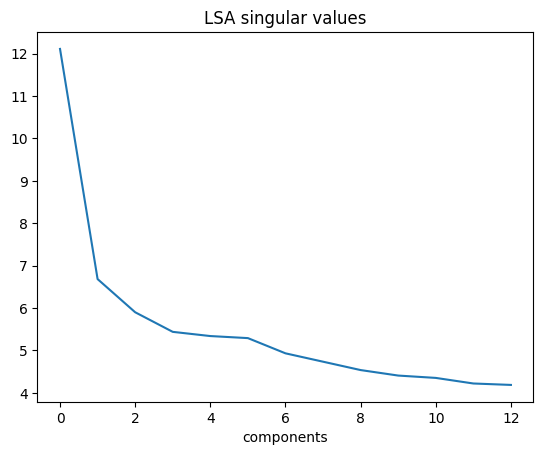

After 5 and 10 the slope of the profile changes, the values are going down


In [ ]:
# plot lsa eigenvalues
plt.plot(range(len(lsa.singular_values_)), lsa.singular_values_)
plt.title('LSA singular values')

plt.xlabel('components')

plt.show()
print('After 5 and 10 the slope of the profile changes, the values are going down')

# Visualization

Plotting the results in a 2D is more meaningful for the **LSA** reduction. In fact due to the **Singular Value Decomposition** the first few dimensions corresponding to  bigger singular values contain most of the information.
This is not given for the other two methods:

**LDA** there is no any enforced hierarchy for topics extracted and the number is suggested by the user (like in K-means clustering).

**NMF** the initial matrix m x n is approximated by the product of two matrix m x p and p x n without particular properties except the non negativity and the small size of p


Using just two componets we can easily see that the documets have been clusterd, plotting an other 2D graph can highlight the remaining classes.

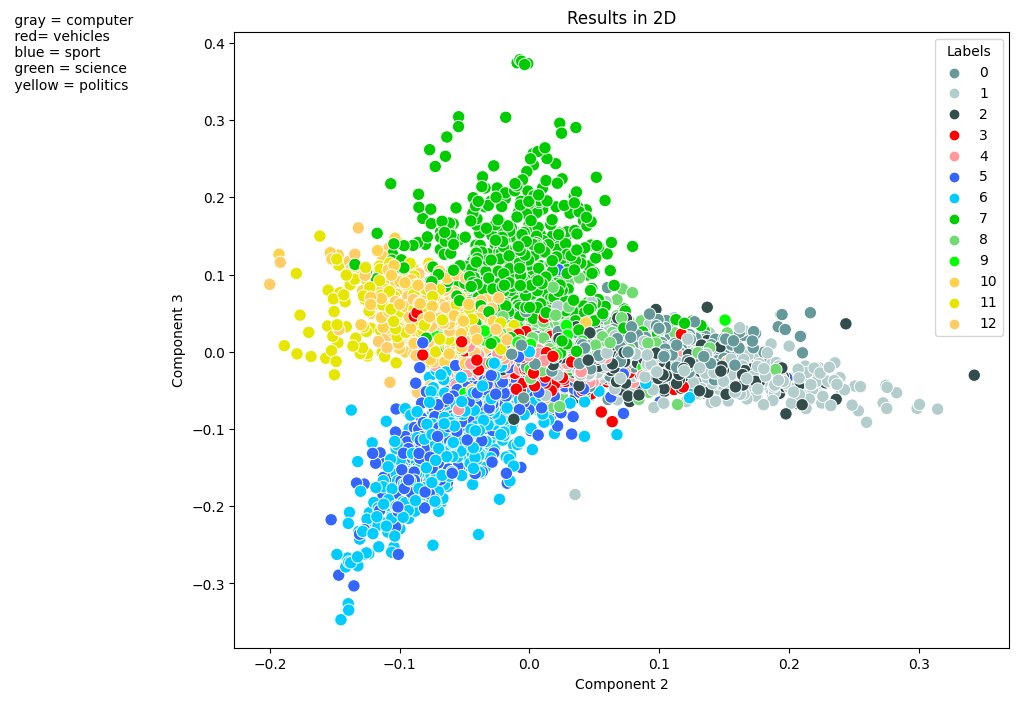

In [ ]:
# 2D grapf of compnents of LSA
plot_lsa_2d(lsa_result, topics, component1=1, component2=2)

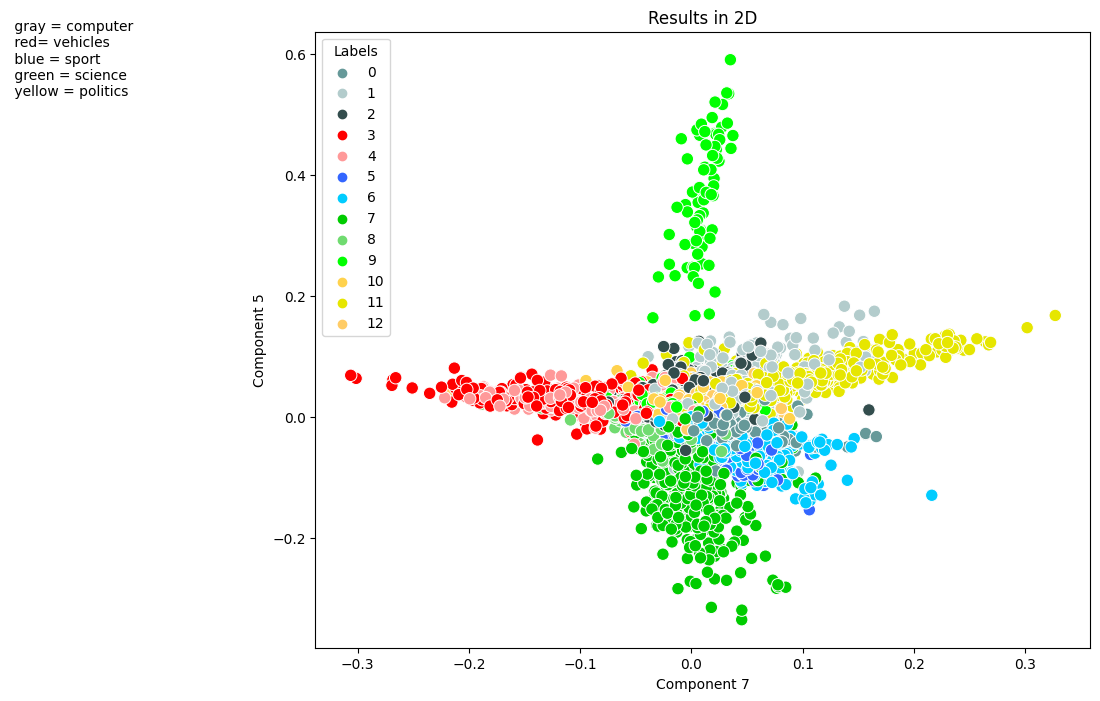

In [ ]:
plot_lsa_2d(lsa_result, topics, component1=6, component2=4)

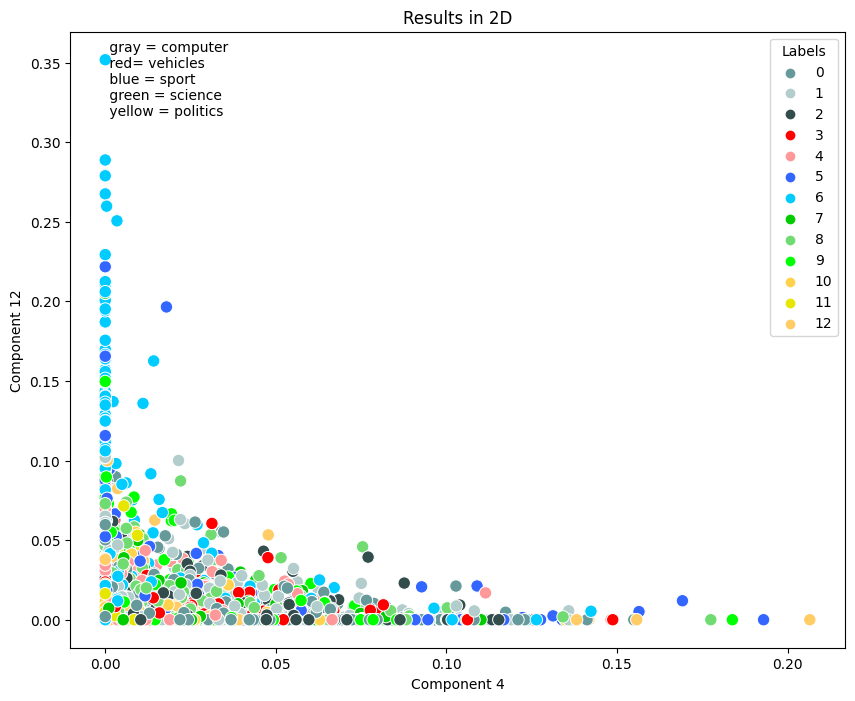

In [ ]:
plot_lsa_2d(nmf_result, topics, component1=3, component2=11)

For LDA and NMF each of the feature extracted can have a impact regardless of the order so an other type of visualization can give us an insight. for each of the classes we plot an histogram representing the presence of the feature in the class.

The heigth of the bar in the histogram is given by the mean of the values that each of the extracted topics get on the classes.

For example is one of the topic extracted is refered to *computer componets*  we can expect that to have an higher average values in the document refer to *hardware* and *electronics* more than *baseball*.

NMF features 
 In NMF We can see that the fearure 2 is important for sport realted classes, while the feature number 10 is importante for the identification of midest classes


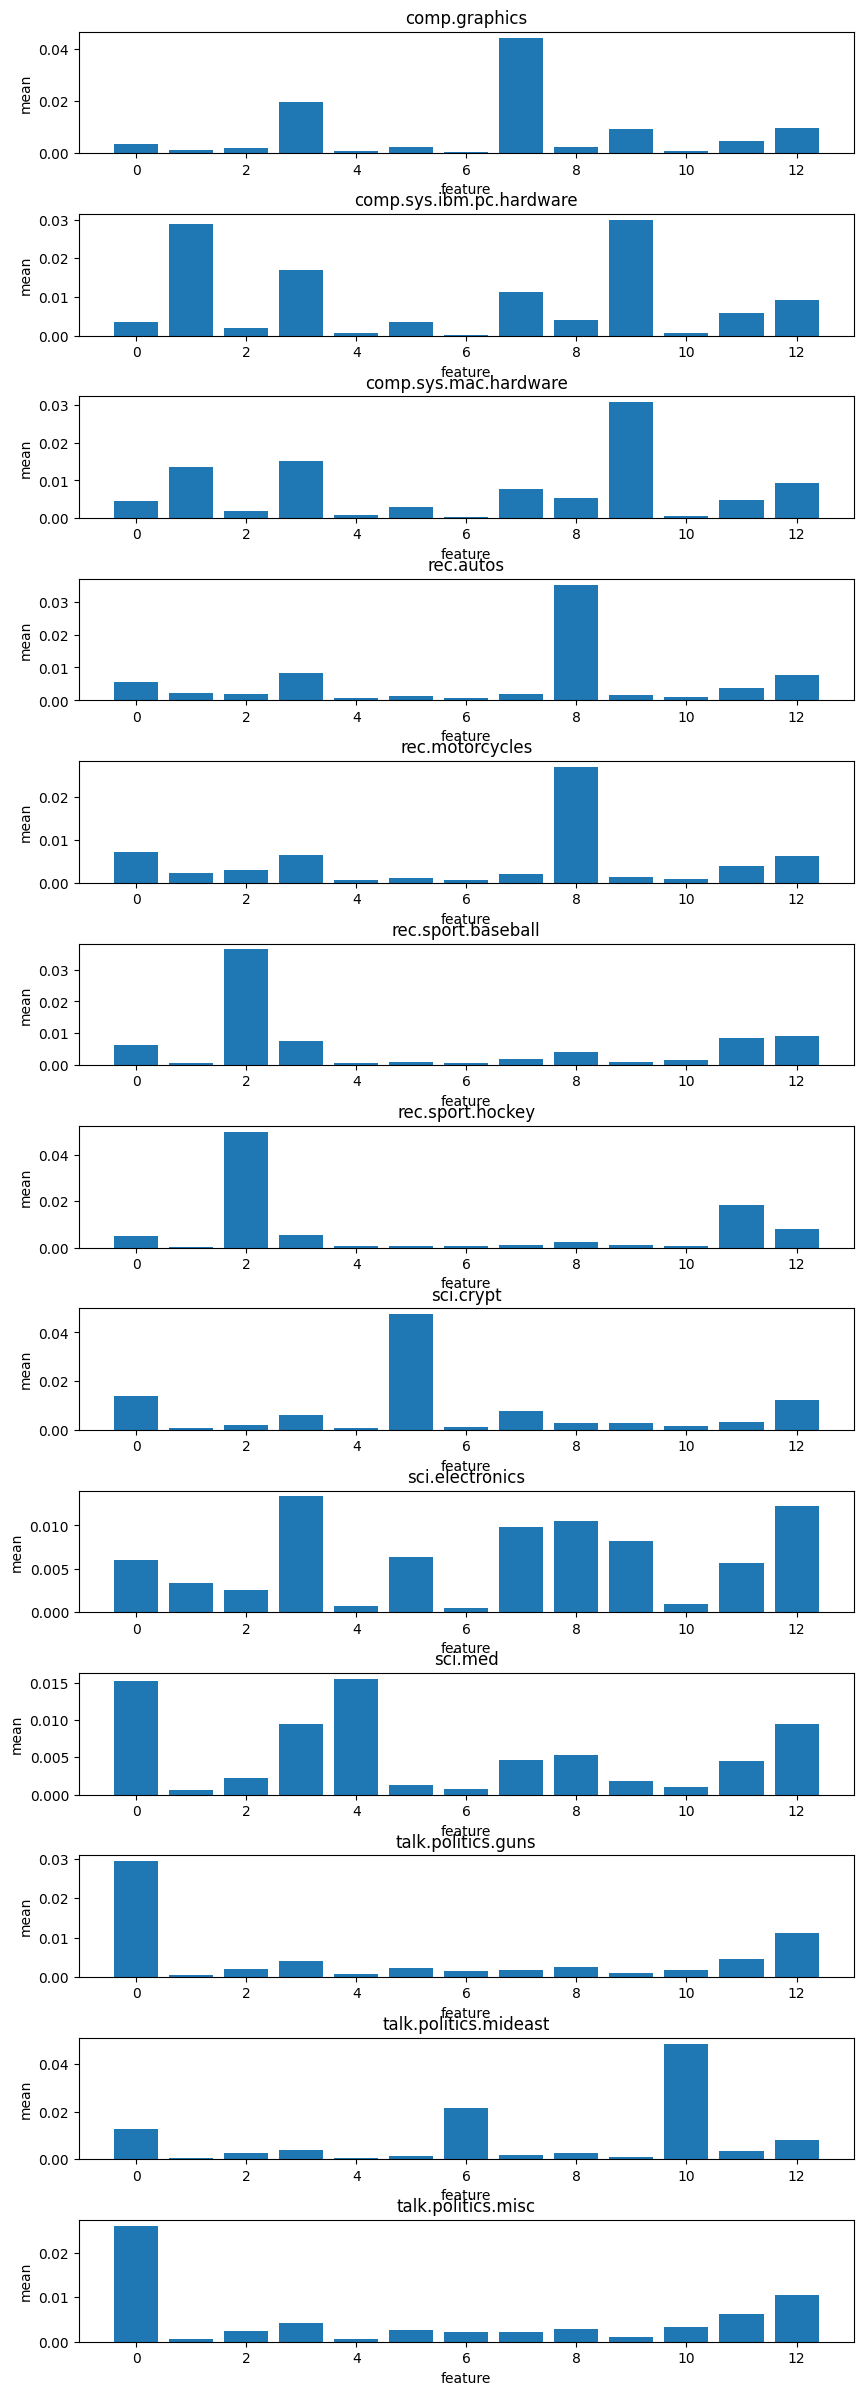

In [ ]:
# for each all the embedding mado of 13 feature are averaged to obtain the average mebedding for each fo the 13 classes
print('NMF features \n', 'In NMF We can see that the fearure 2 is important for sport realted classes, while the feature number 10 is importante for the identification of midest classes')
visualize_features(nmf_result, topics, categories = categories)


LDA features 
 In LDA We can see that the fearure 6 and 11 are important for computer realted classes


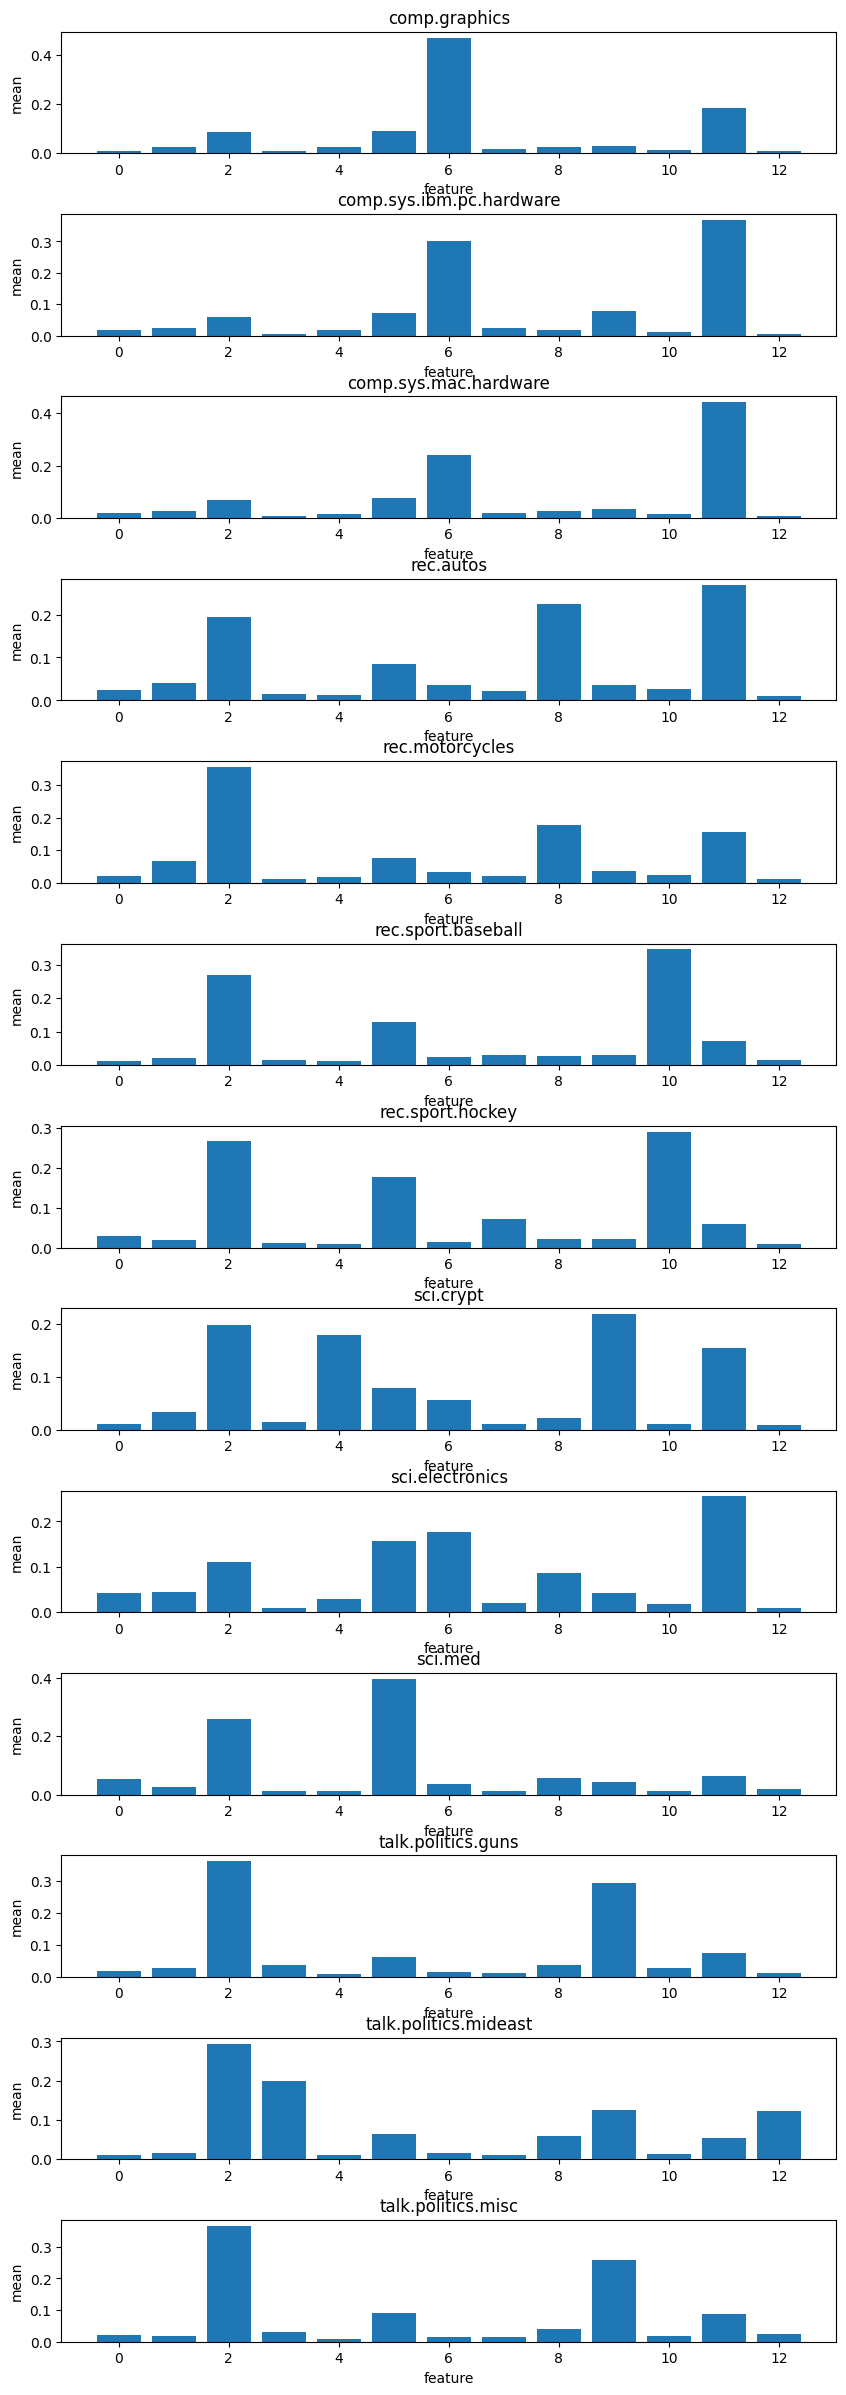

In [ ]:
# for each all the embedding mado of 13 feature are averaged to obtain the average mebedding for each fo the 13 classes
print('LDA features \n', 'In LDA We can see that the fearure 6 and 11 are important for computer realted classes')
visualize_features(lda_result, topics, categories = categories)

# Cosine similarity

In [ ]:
lsa_centroids = centroids_classes(lsa_result, topics, categories = categories)
top_terms_per_topic = []
n_top_terms =10

for class_idx in range(0,len(categories)):
  centroid = np.array(lsa_centroids[class_idx][1:])
  similarity_array = []

  for term in lsa.components_.T:
    similarity_array.append(cosine_similarity(centroid.reshape(1,-1), term[1:].reshape(1,-1))*np.linalg.norm(term[1:].reshape(1,-1), ord=2)**(1/3)) # *np.linalg.norm(term.reshape(1,-1)) **0.5 works

  similarity_array = np.array(similarity_array).reshape([len(similarity_array)])
  top_term_indices = similarity_array.argsort()[::-1][:n_top_terms] #indices tha would sort the array so you have the word with the max importance
  top_terms = [my_words[i] for i in top_term_indices]
  top_terms_per_topic.append(top_terms)

In [ ]:
lsa_centroids = centroids_classes(nmf_result, topics, categories = categories)
top_terms_per_topic = []
n_top_terms =10

for class_idx in range(0,len(categories)):
  centroid = np.array(lsa_centroids[class_idx])
  similarity_array = []

  for term in nmf.components_.T:
    similarity_array.append(cosine_similarity(centroid.reshape(1,-1), term.reshape(1,-1))*np.linalg.norm(term.reshape(1,-1), ord=2)**(1/3)) # *np.linalg.norm(term.reshape(1,-1)) **0.5 works

  similarity_array = np.array(similarity_array).reshape([len(similarity_array)])
  top_term_indices = similarity_array.argsort()[::-1][:n_top_terms] #indices tha would sort the array so you have the word with the max importance
  top_terms = [my_words[i] for i in top_term_indices]
  top_terms_per_topic.append(top_terms)

In [ ]:
np.linalg.norm(term.reshape(1,-1), ord = 2)**(1/5)
np.argsort(term_norms)[::-1]
[np.linalg.norm(i, ord=2) for i in lsa_centroids ]
cosine_similarities = pairwise_distances(lsa_centroids, metric='cosine').round(2)
cosine_similarities
cosine_similarity(np.array(lsa_centroids),np.array(lsa_centroids))


array([[1.        , 0.80011554, 0.82785224, 0.51351759, 0.53097468,
        0.5031304 , 0.36220058, 0.57481272, 0.81453944, 0.66727922,
        0.47685122, 0.38696717, 0.51502311],
       [0.80011554, 1.        , 0.97263434, 0.56695333, 0.55866307,
        0.47793783, 0.36517109, 0.55810193, 0.82314561, 0.61648526,
        0.42280901, 0.31282595, 0.46616187],
       [0.82785224, 0.97263434, 1.        , 0.6682333 , 0.68738081,
        0.54564631, 0.40534992, 0.60310004, 0.90649381, 0.72824278,
        0.48345846, 0.37824449, 0.54235649],
       [0.51351759, 0.56695333, 0.6682333 , 1.        , 0.93743834,
        0.65055176, 0.47123129, 0.58690889, 0.83269812, 0.78199304,
        0.65667997, 0.47579234, 0.70370493],
       [0.53097468, 0.55866307, 0.68738081, 0.93743834, 1.        ,
        0.73930672, 0.55681507, 0.62679877, 0.87621361, 0.89960005,
        0.69942705, 0.55691188, 0.76521563],
       [0.5031304 , 0.47793783, 0.54564631, 0.65055176, 0.73930672,
        1.        , 0.96247

In [ ]:

for i in range(13):
    label = f'{label2id[i]} :'
    terms = top_terms_per_topic[i]
    print(f'{label.ljust(max_width)} {terms}') #**1/2

comp.graphics :            ['graphics', 'image', 'program', 'file', 'ftp', 'files', 'software', 'gif', 'format', 'available']
comp.sys.ibm.pc.hardware : ['mac', 'card', 'pc', 'port', 'board', 'ram', 'scsi', 'memory', 'controller', 'need']
comp.sys.mac.hardware :    ['mac', 'card', 'monitor', 'apple', 'pc', 'port', 'board', 'video', 'need', 'memory']
rec.autos :                ['car', 'bike', 'cars', 'engine', 'miles', 'oil', 'dealer', 'ford', 'ride', 'rear']
rec.motorcycles :          ['bike', 'car', 'ride', 'cars', 'engine', 'riding', 'front', 'bikes', 'oil', 'miles']
rec.sport.baseball :       ['game', 'team', 'games', 'year', 'hockey', 'last', 'season', 'baseball', 'play', 'win']
rec.sport.hockey :         ['game', 'team', 'games', 'hockey', 'year', 'season', 'play', 'last', 'baseball', 'win']
sci.crypt :                ['key', 'encryption', 'clipper', 'chip', 'keys', 'escrow', 'algorithm', 'government', 'nsa', 'security']
sci.electronics :          ['used', 'car', 'use', 'work', 'p

In [ ]:
for i in range(13): # remove first feature
    label = f'{label2id[i]} :'
    terms = top_terms_per_topic[i]
    print(f'{label.ljust(max_width)} {terms}') # **2

comp.graphics :            ['graphics', 'program', 'software', 'file', 'image', 'files', 'available', 'ftp', 'computer', 'find']
comp.sys.ibm.pc.hardware : ['need', 'mac', 'pc', 'system', 'card', 'use', 'work', 'computer', 'board', 'port']
comp.sys.mac.hardware :    ['need', 'mac', 'work', 'use', 'system', 'problem', 'get', 'computer', 'also', 'apple']
rec.autos :                ['car', 'bike', 'new', 'cars', 'much', 'also', 'engine', 'around', 'back', 'well']
rec.motorcycles :          ['get', 'one', 'bike', 'well', 'car', 'back', 'around', 'much', 'take', 'got']
rec.sport.baseball :       ['game', 'year', 'team', 'last', 'games', 'first', 'well', 'hockey', 'play', 'see']
rec.sport.hockey :         ['game', 'team', 'games', 'year', 'last', 'hockey', 'season', 'play', 'win', 'baseball']
sci.crypt :                ['key', 'encryption', 'clipper', 'chip', 'government', 'keys', 'use', 'public', 'law', 'escrow']
sci.electronics :          ['one', 'also', 'use', 'used', 'need', 'get', 'much

In [ ]:
np.array(similarity_array).reshape([len(similarity_array)])

array([-0.03894421,  0.17709987, -0.06430684, ..., -0.02280433,
       -0.02433497,  0.14781092])

# Classification
The aim of feature selection is to reduce the size of the data but without loosing most of the information. So a model if fitted with the new features in order to see if their are enough to fit a classification model.

## Results

The classification done using **LSA** and **NMf** feature has the best perfromances.
The feauture importance is bigger for the first features in **LSA** while it is distrubuted more randomly for the other methods.

**Common errors**  miscalssification between news related to the computer graphics and electronics are common, the other most common misclassification are between elements of the same 5 aggregated-classes.

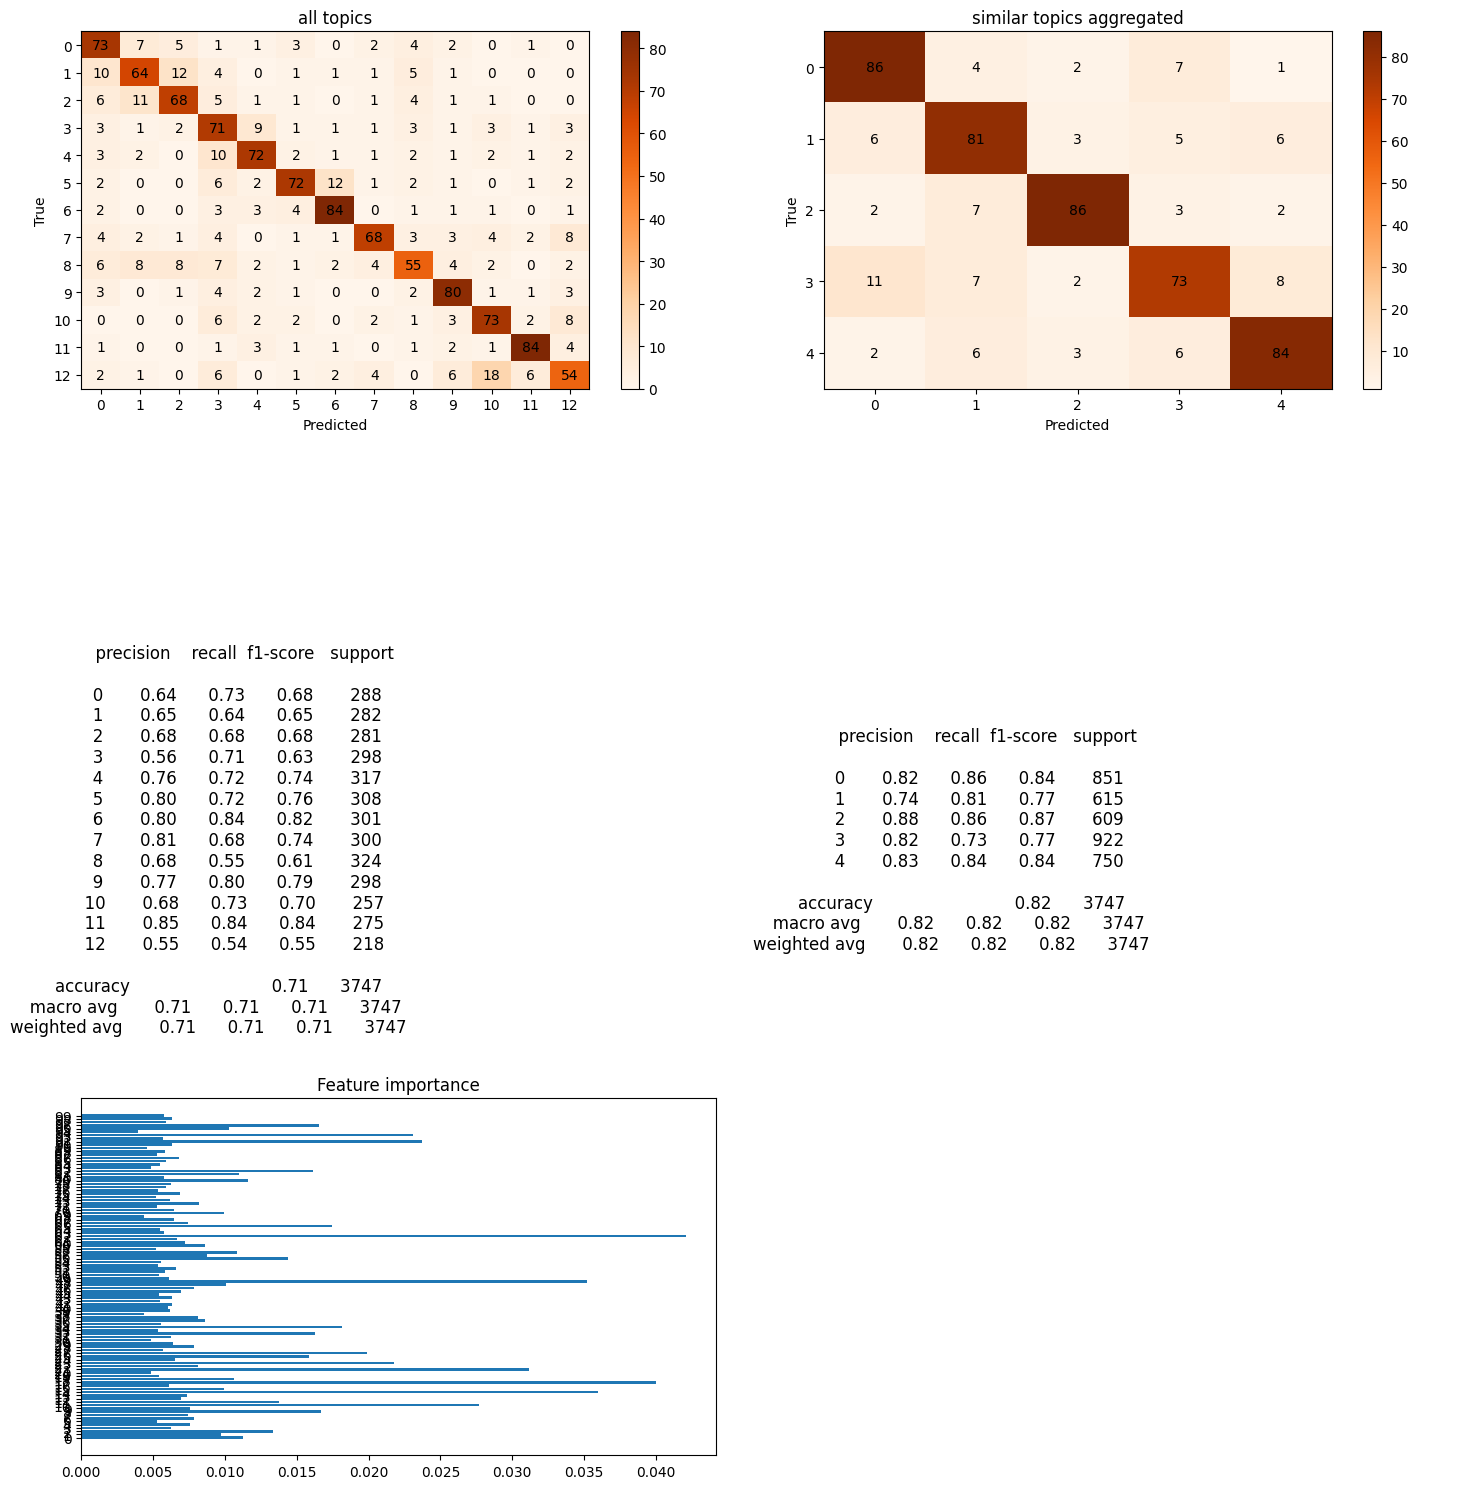

In [ ]:
evaluator(nmf_result, topics, dict_related_categories = dict_related_categories, categories = None)

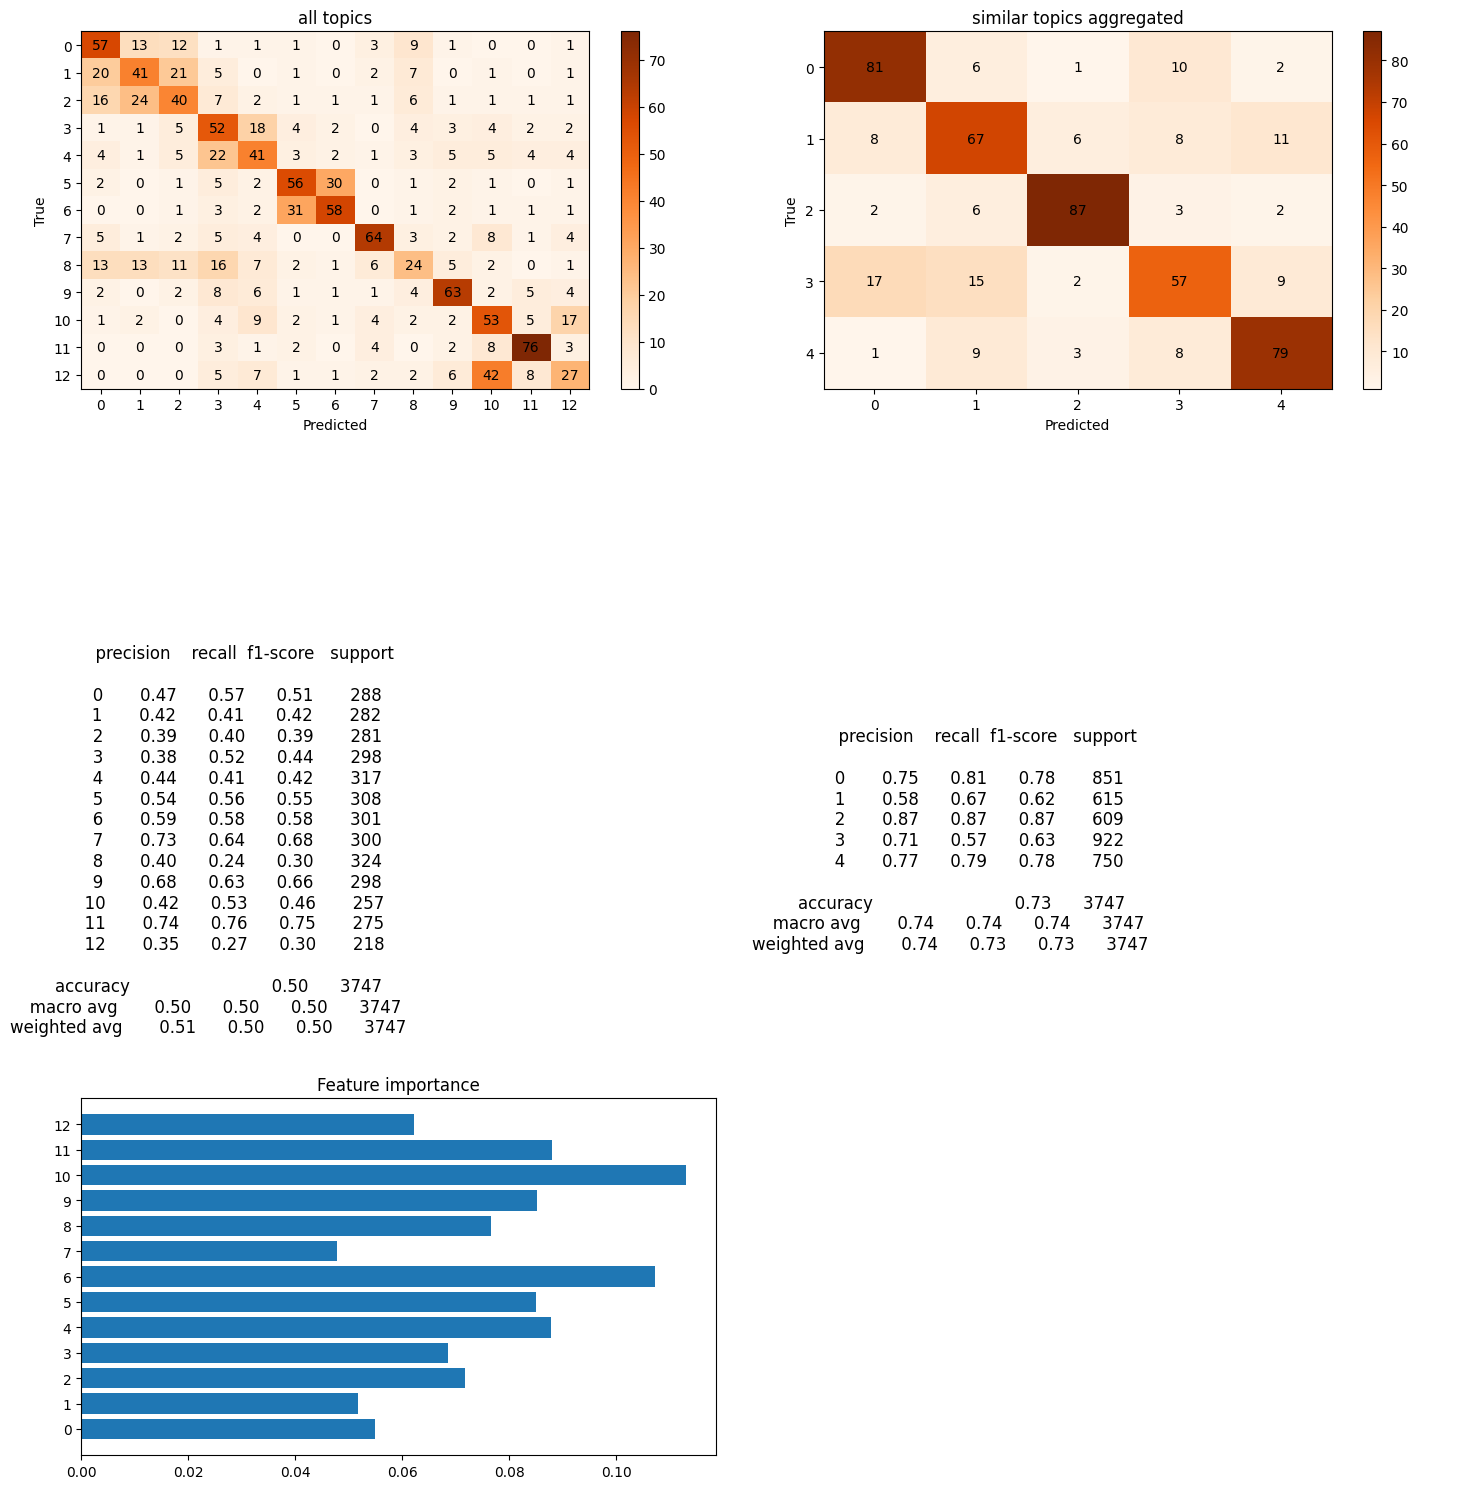

In [ ]:
evaluator(lda_result, topics, dict_related_categories = dict_related_categories, categories = None)

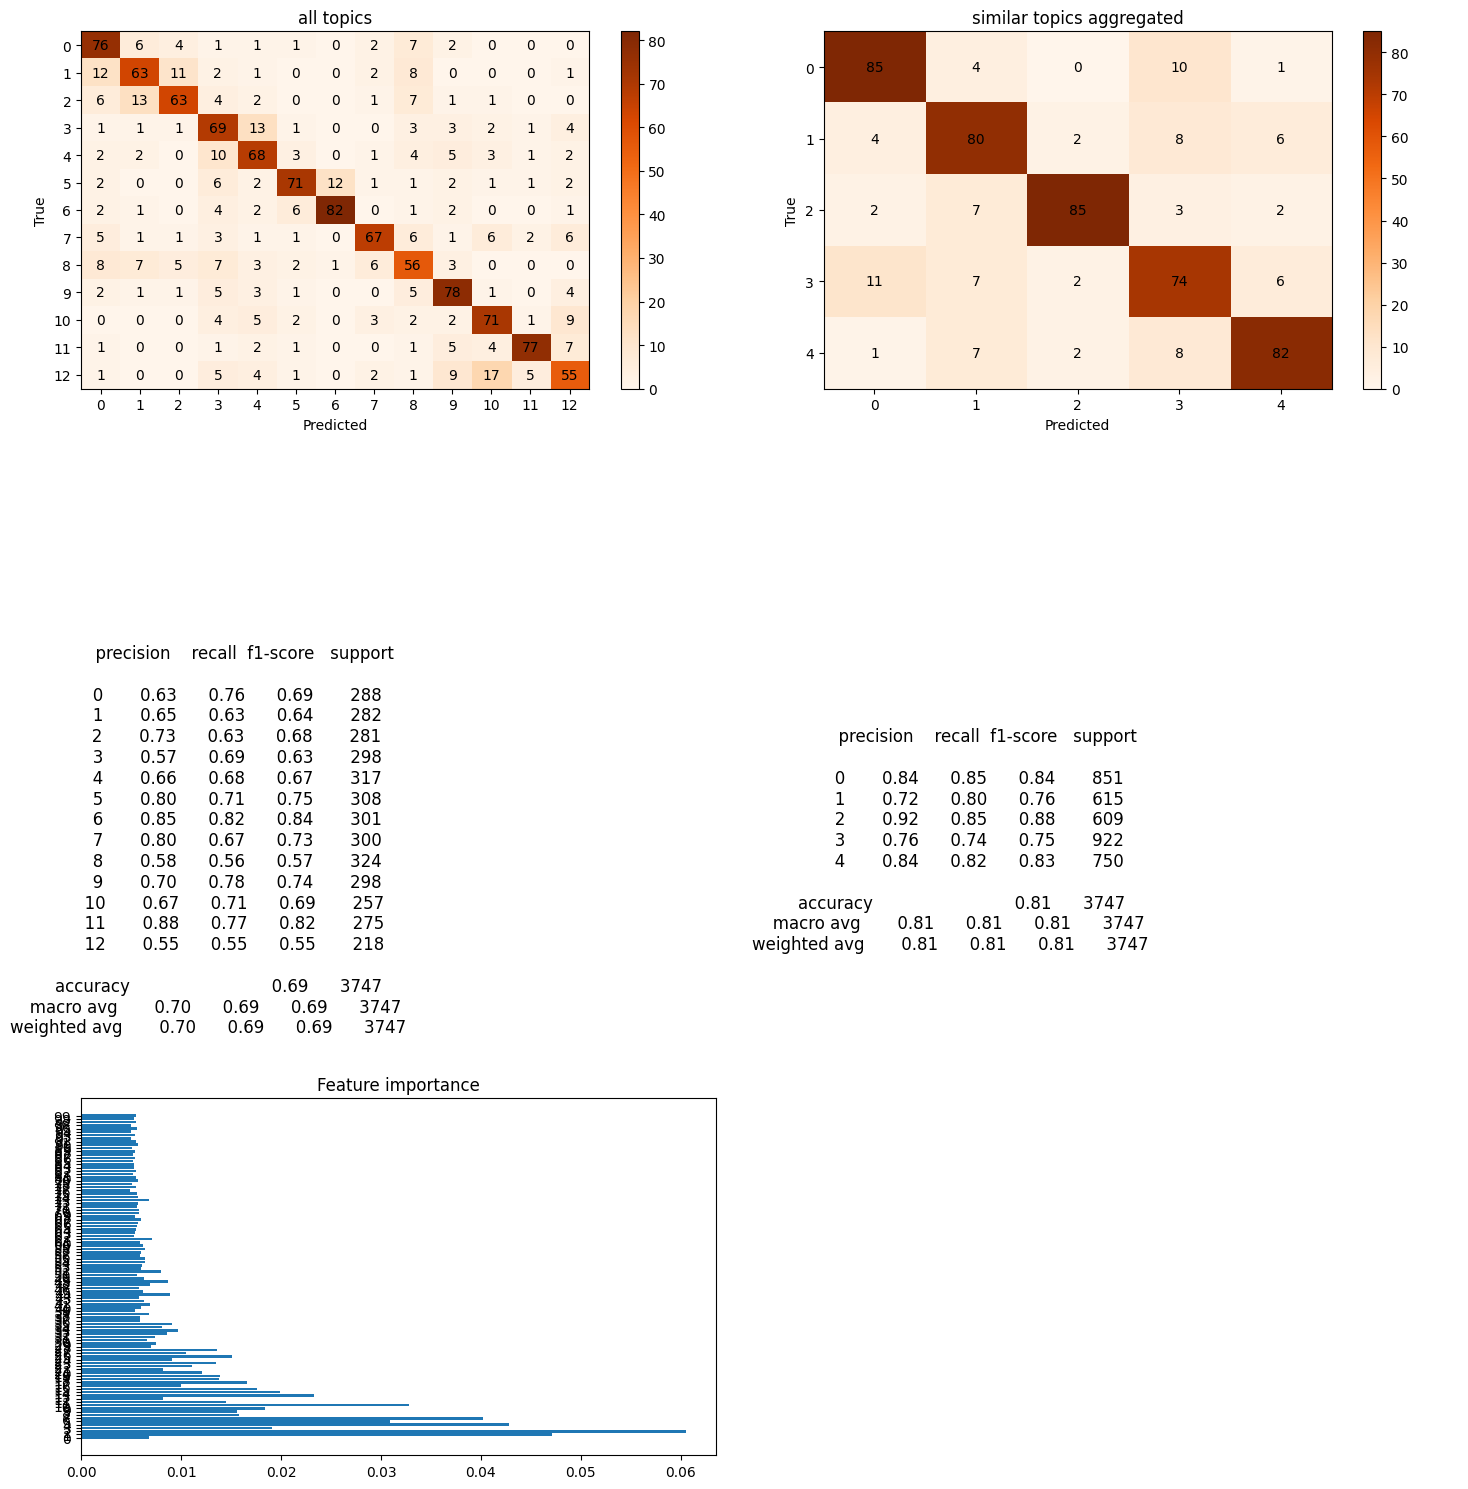

In [ ]:
evaluator(lsa_result, topics, dict_related_categories = dict_related_categories, categories = None)

# Explainability (Components inspection)
So far **LSA** has had the best performance under all aspects, but the fact that encodes most the information in few signed dimensions, while the various topic extract by **LDA** and the non negativity of **NMF** factorization can make the encoding more interpretable.
Once the topic of the features are understood is can be possible possible to understand if a long document contains more than one topic.

In [ ]:
document_topics = nmf_result.argmax(axis=1)

top_terms_per_topic = []
n_top_terms =10
for topic_idx in range(0,len(categories)):
    top_term_indices = nmf.components_[topic_idx].argsort()[::-1][:n_top_terms] #indices tha would sort the array so you have the word with the max importance
    top_terms = [my_words[i] for i in top_term_indices]
    top_terms_per_topic.append(top_terms)

In [ ]:
print('The component are 13 as we set, and for each word there is a value \n')
print('Shape of nmf componets',nmf.components_.shape)
#print(lda.components_.shape)
#print(lsa.components_.shape)

The component are 13 as we set, and for each word there is a value 

Shape of nmf componets (13, 36498)


In [ ]:
print('We have noticed that in NMF the topic 2 in importance for sports, while the 10 for mideast \n')
for i in range(13):
  print(f'topic  {i} :',top_terms_per_topic[i])
  #print('topic {} :',top_terms_per_topic[10])

We have noticed that in NMF the topic 2 in importance for sports, while the 10 for mideast 

topic  0 : ['people', 'one', 'gun', 'right', 'government', 'us', 'get', 'well', 'know', 'even']
topic  1 : ['drive', 'scsi', 'ide', 'drives', 'controller', 'disk', 'hard', 'floppy', 'hd', 'bus']
topic  2 : ['game', 'team', 'games', 'year', 'hockey', 'baseball', 'last', 'season', 'players', 'espn']
topic  3 : ['thanks', 'please', 'anyone', 'know', 'mail', 'advance', 'address', 'info', 'email', 'someone']
topic  4 : ['geb', 'dsl', 'n3jxp', 'cadre', 'chastity', 'skepticism', 'intellect', 'pitt', 'shameful', 'gordon']
topic  5 : ['key', 'chip', 'encryption', 'clipper', 'keys', 'escrow', 'government', 'algorithm', 'phone', 'system']
topic  6 : ['armenian', 'armenians', 'turkish', 'genocide', 'armenia', 'turkey', 'muslim', 'turks', 'soviet', 'russian']
topic  7 : ['graphics', 'image', 'program', 'file', 'files', 'format', 'software', 'ftp', 'gif', 'available']
topic  8 : ['car', 'bike', 'cars', 'engi

In [ ]:
top_terms_per_topic = []
for topic_idx in range(len(categories)):
    top_term_indices = lda.components_[topic_idx].argsort()[::-1][:n_top_terms]
    top_terms = [my_words[i] for i in top_term_indices]
    top_terms_per_topic.append(top_terms)

In [ ]:
print('We have notice that in LDA the topic 6 and 11 in importance for computer classes \n')
for i in range(13):
  print(f'topic  {i} :',top_terms_per_topic[i])

We have notice that in LDA the topic 6 and 11 in importance for computer classes 

topic  0 : ['health', 'db', 'cable', 'medical', 'canada', 'drugs', 'drug', 'insurance', 'dr', 'canadian']
topic  1 : ['edu', 'com', 'cs', 'ca', 'list', 'university', 'dod', 'org', 'send', 'david']
topic  2 : ['would', 'one', 'people', 'know', 'get', 'well', 'even', 'said', 'going', 'see']
topic  3 : ['armenian', 'armenians', 'jews', 'turkish', 'people', 'turkey', 'killed', '000', 'russian', 'history']
topic  4 : ['key', 'encryption', 'chip', 'clipper', 'keys', 'algorithm', 'message', 'privacy', 'security', 'public']
topic  5 : ['one', 'may', 'also', 'would', 'get', 'number', 'use', 'new', 'two', 'many']
topic  6 : ['image', 'file', 'jpeg', 'software', 'graphics', 'use', 'data', 'program', 'pc', 'available']
topic  7 : ['10', '25', '12', '11', '15', '16', '17', '00', '20', '14']
topic  8 : ['car', 'bike', 'cars', 'used', 'water', 'engine', 'oil', 'front', 'miles', 'one']
topic  9 : ['government', 'people'

In [ ]:
print('The same can be done for LSA the also extracting extremely negative values can be important for the classification \n')
top_pos_terms_per_topic = []
top_neg_terms_per_topic = []
for topic_idx in range(len(categories)):
    top_term_indices = lsa.components_[topic_idx].argsort()[:n_top_terms]

    top_terms = [my_words[i] for i in top_term_indices]
    top_neg_terms_per_topic.append(top_terms)
    top_term_indices = lsa.components_[topic_idx].argsort()[::-1][:n_top_terms]

    top_terms = [my_words[i] for i in top_term_indices]
    top_pos_terms_per_topic.append(top_terms)

The same can be done for LSA the also extracting extremely negative values can be important for the classification 



# Performance with different number of features/topic extracted

In [ ]:
lsa_score,lda_score,nmf_score = [],[],[]
time_lsa, time_lda ,time_nmf = [],[],[]
topic_list = [1,2,3,5,7,10,13, 15,20,25, 30, 40, 50, 80, 100 ]
for n_topic in topic_list:
    print('evaluating for topics = ', n_topic)
    tmp1,tmp2,tmp3, time1,time2,time3 = run_test(n_topic, tfidf_matrix, count_matrix,  topics)
    lsa_score.append(tmp1)
    lda_score.append(tmp2)
    nmf_score.append(tmp3)
    time_lsa.append(time1)
    time_lda.append(time2)
    time_nmf.append(time3)

evaluating for topics =  1
evaluating for topics =  2
evaluating for topics =  3
evaluating for topics =  5
evaluating for topics =  7
evaluating for topics =  10
evaluating for topics =  13
evaluating for topics =  15
evaluating for topics =  20
evaluating for topics =  25
evaluating for topics =  30


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


evaluating for topics =  40
evaluating for topics =  50
evaluating for topics =  80


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


evaluating for topics =  100


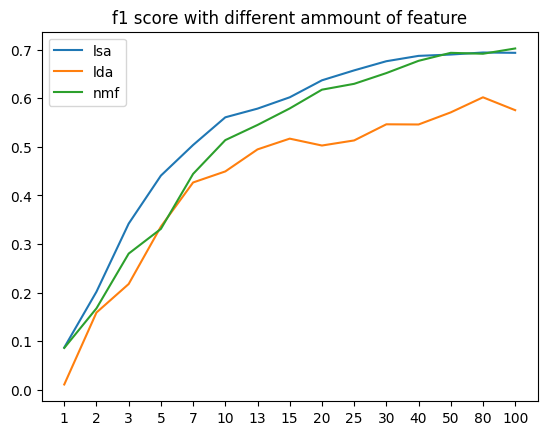

In [ ]:
plt.plot([str(topic) for topic in topic_list], lsa_score, label = 'lsa')
plt.plot([str(topic) for topic in topic_list], lda_score, label = 'lda')
plt.plot([str(topic) for topic in topic_list], nmf_score, label = 'nmf')
plt.legend()
plt.title('f1 score with different ammount of feature')
plt.show()

## Comments
**F1 score**

As expected for the few feature the **LSA** f1 score encreases fast (as known they contain most of the information), the it plateau. for few ammount of feature **NMF** and **LDA** have similar performances, than **NMF** seem to perform as good as **LSA** for big numbers of features. The documets analysed have 177 word on average so taking 50 feature can be not be the best way to reduce the dimension, but still is way smaller the the tfidf matrix or the count matrix (they have size n_docs x num_word instead of n_docs x num_features). We will also see that LLM based feature extractores will need more features to do the trick.

**Time for computation**

The time for the **LSA** is smaller that the time needed for the other methods and encreases slowly. **LDA** in general the slower method (for this reason i have limted the number of iteration), **NMF** can be slow if the method does not (or struggles to) converge and the number of iteration required increases. (**NOTE** the NMF factorization is not always given and is obatained by optimization for this reason it may not converge).



In [ ]:
print(lda_result.shape)
print(lsa_result.shape)
print(tfidf_matrix.shape)
print(count_matrix.shape)

(12487, 13)
(12487, 13)
(12487, 36498)
(12487, 36498)


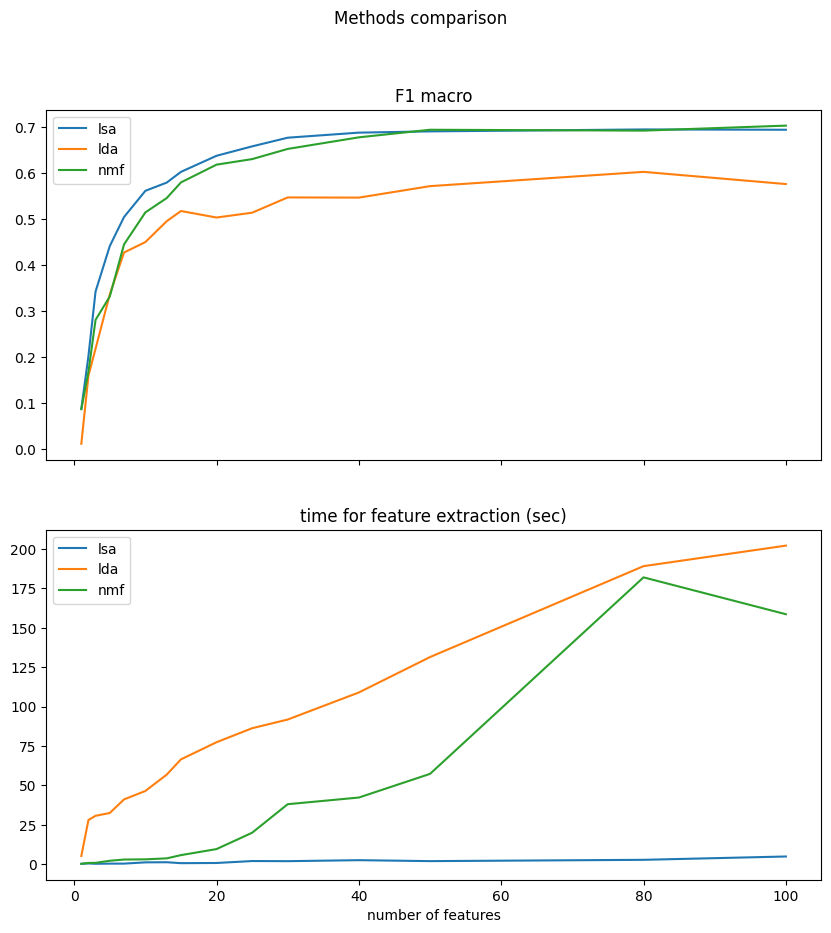

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

# Plot data on the first subplot
ax1.plot([topic for topic in topic_list], lsa_score, label = 'lsa')
ax1.plot([topic for topic in topic_list], lda_score, label = 'lda')
ax1.plot([topic for topic in topic_list], nmf_score, label = 'nmf')
ax1.set_title('F1 macro')
ax1.legend()

# Plot data on the second subplot
ax2.plot([topic for topic in topic_list], time_lsa, label = 'lsa')
ax2.plot([topic for topic in topic_list], time_lda, label = 'lda')
ax2.plot([topic for topic in topic_list], time_nmf, label = 'nmf')
ax2.set_title('time for feature extraction (sec)')
ax2.legend()

# Add labels and titles
plt.xlabel('number of features')
plt.suptitle('Methods comparison')

# Show the plot
plt.show()

# Using pretrained language model
Documents representation  can be created or extracted from Language model and can be used for classification or other downstream tasks. In this section two ideas are tested:


*   Using **distil-BERT** last Hidden state as representation of document.
*   **Universal Sentence Encoder  (USE)** from Google.



## distil-BERT

For the classification is used the output of the last hidden layer, it contains the [CLS] followed by the token embedding.
The [CLS] should contain a rich representation of the entire input sentence, but without the fine-tuning is not given that the representation will be meaningful for our task.

The [CLS] and token embedding, are feed to the classifier, to reduce size mean and argmax are used. Unfortunately without any fine-tuning this is not significantly better than a Dummy classifier that always select the most common label.

<div>
<img src="https://editor.analyticsvidhya.com/uploads/17621aa.png" width="500"/>
</div>

In [ ]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories = categories,)
documents = newsgroups.data
topics = newsgroups.target
print(len(documents))

12487


In [ ]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')
model = BertModel.from_pretrained("distilbert-base-uncased")
x_train, x_val, label_train, label_val = train_test_split(documents, topics, test_size=0.3, random_state=random_state)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of BertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.layer.10.attention.self.query.weight', 'encoder.layer.9.attention.output.dense.weight', 'encoder.layer.6.attention.output.LayerNorm.bias', 'encoder.layer.9.intermediate.dense.bias', 'encoder.layer.8.output.dense.bias', 'encoder.layer.6.attention.output.dense.weight', 'encoder.layer.11.attention.self.key.weight', 'encoder.layer.2.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.4.attention.output.dense.bias', 'encoder.layer.8.attention.self.value.weight', 'encoder.layer.5.attention.self.query.weight', 'encoder.layer.1.output.dense.weight', 'encoder.layer.3.attention.self.query.bias', 'encoder.layer.3.intermediate.dense.weight', 'encoder.layer.8.attention.output.LayerNorm.bias', 'encoder.layer.9.attention.output.LayerNorm.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.10.attention.

In [ ]:
n_features = 100
max_length = 256
batch_size =64
encode_train = []

for i in tqdm(range(0, len(x_train[:2000]), batch_size)):
    batch_x_train = x_train[i:i+batch_size]

    # Tokenize the batch
    tokenized_batch = tokenizer(
        batch_x_train,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=max_length
    )

    # Get the [CLS] hidden states for the batch
    with torch.no_grad():
        #output = model(**tokenized_batch).last_hidden_state[:, 0, :] get the cls from the model
        output = model(**tokenized_batch).last_hidden_state
        outputing = model(**tokenized_batch)
        print(outputing)
        print(output.shape)

    encode_train.append(output)

# Concatenate the batched outputs
encode_train = torch.cat(encode_train, dim=0)

  3%|▎         | 1/32 [01:31<47:03, 91.08s/it]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 1.4728e+00, -4.8523e-01, -1.1339e+00,  ..., -1.5154e-01,
           6.1917e-01, -9.1827e-01],
         [ 1.3787e+00, -1.6089e+00, -5.7152e-01,  ..., -1.0748e+00,
           6.1433e-02, -8.2321e-02],
         [ 1.2977e+00, -2.2818e-01, -1.9782e+00,  ..., -1.3490e+00,
           7.5229e-01, -2.1028e-01],
         ...,
         [ 7.7881e-01, -6.8116e-01, -6.0799e-01,  ..., -1.0552e+00,
          -3.0076e-01, -3.4511e-01],
         [ 1.3999e+00,  5.4597e-01, -4.9620e-01,  ..., -7.0024e-01,
           3.1431e-01, -9.3152e-01],
         [ 1.1167e+00,  5.8291e-01, -6.7579e-01,  ..., -1.5824e+00,
          -4.5438e-01, -1.0731e+00]],

        [[ 1.4455e+00, -2.6714e-01, -1.5897e+00,  ...,  6.3020e-02,
           4.0792e-01, -9.7000e-01],
         [ 1.1449e+00,  2.7668e-02, -5.2150e-01,  ..., -4.7445e-01,
           9.5816e-01, -7.9850e-02],
         [ 1.7239e+00, -3.1030e-01, -1.5781e+00,  ..., -3.6108e-01,
           6.

  3%|▎         | 1/32 [02:00<1:02:24, 120.80s/it]


KeyboardInterrupt: ignored

In [ ]:
encode_train.shape

torch.Size([2048, 256, 768])

In [ ]:
encode_val = []

for i in tqdm(range(0, len(x_train[:500]), batch_size)):
    batch_x_val= x_val[i:i+batch_size]

    # Tokenize the batch
    tokenized_batch = tokenizer(
        batch_x_train,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=max_length
    )

    # Get the [CLS] hidden states for the batch
    with torch.no_grad():
        output = model(**tokenized_batch).last_hidden_state[:, 0, :]
    encode_val.append(output)

# Concatenate the batched outputs
encode_val = torch.cat(encode_val, dim=0)

100%|██████████| 8/8 [10:24<00:00, 78.00s/it]


In [ ]:
print(encode_train.shape)
#encode_reduced = encode_train.detach().numpy().mean(axis=1)
#encode_reduced = encode_train[:,:,:].argmax(axis=1)
encode_reduced = encode_train[:,0,:]
encode_val_reduced = encode_val
print(encode_reduced.shape)

torch.Size([2048, 256, 768])
torch.Size([2048, 768])


In [ ]:
clf = DummyClassifier(random_state=0)
clf.fit(encode_reduced, [dict_related_categories[i] for i in label_val[: encode_reduced.shape[0]]])
print(clf.score(encode_val_reduced, [dict_related_categories[i] for i in label_val[: encode_val_reduced.shape[0]]]))

0.2578125


In [ ]:
rf = RandomForestClassifier()
rf.fit(encode_reduced,[dict_related_categories[i] for i in label_train[: encode_reduced.shape[0]]])
print(rf.score(encode_reduced,[dict_related_categories[i] for i in label_val[: encode_reduced.shape[0]]]))
predictions = rf.predict(encode_val_reduced)
F1_score = f1_score([dict_related_categories[i] for i in label_val[: encode_val_reduced.shape[0]]], predictions, average = 'macro')
print(F1_score)

0.19677734375
0.19483881595888775


In [ ]:
report1 = classification_report([dict_related_categories[i] for i in label_val[: encode_val.shape[0]]], predictions, )
print(report1)

              precision    recall  f1-score   support

           0       0.26      0.18      0.21       117
           1       0.14      0.20      0.17        81
           2       0.12      0.07      0.09        80
           3       0.24      0.33      0.28       132
           4       0.23      0.22      0.22       102

    accuracy                           0.21       512
   macro avg       0.20      0.20      0.19       512
weighted avg       0.21      0.21      0.21       512



In [ ]:
cm = ((confusion_matrix([dict_related_categories[i] for i in label_val[: encode_val.shape[0]]], predictions, normalize = 'true'))*100).round(0)
print(cm)

[[18. 23. 14. 31. 15.]
 [15. 20. 10. 40. 16.]
 [15. 24.  8. 35. 19.]
 [17. 20.  8. 33. 22.]
 [13. 23.  7. 36. 22.]]


## Universal Sentence Encoder

The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

<div>
<img src="https://amitness.com/images/use-overall-pipeline.png" width="500"/>
</div>


In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
batch_size = 256
num_batches = len(documents) // batch_size + 1  # Calculate the number of batches

embeddings = []  # Store the embeddings

# Process sentences in batches
for i in tqdm(range(num_batches)):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(documents) +1)
    batch = documents[start:end]

    # Encode the batch of sentences
    batch_embeddings = embed(batch)
    embeddings.extend(np.array(batch_embeddings))

100%|██████████| 49/49 [01:11<00:00,  1.47s/it]


In [ ]:
batch_size = 256
num_batches = len(my_words) // batch_size + 1  # Calculate the number of batches

word_embeddings = []  # Store the embeddings
word_list = list(my_words.values())
# Process sentences in batches
for i in tqdm(range(num_batches)):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(my_words) +1)
    batch = word_list[start:end]

    # Encode the batch of sentences
    batch_embeddings = embed(batch)
    word_embeddings.extend(np.array(batch_embeddings))

100%|██████████| 143/143 [00:01<00:00, 93.49it/s]


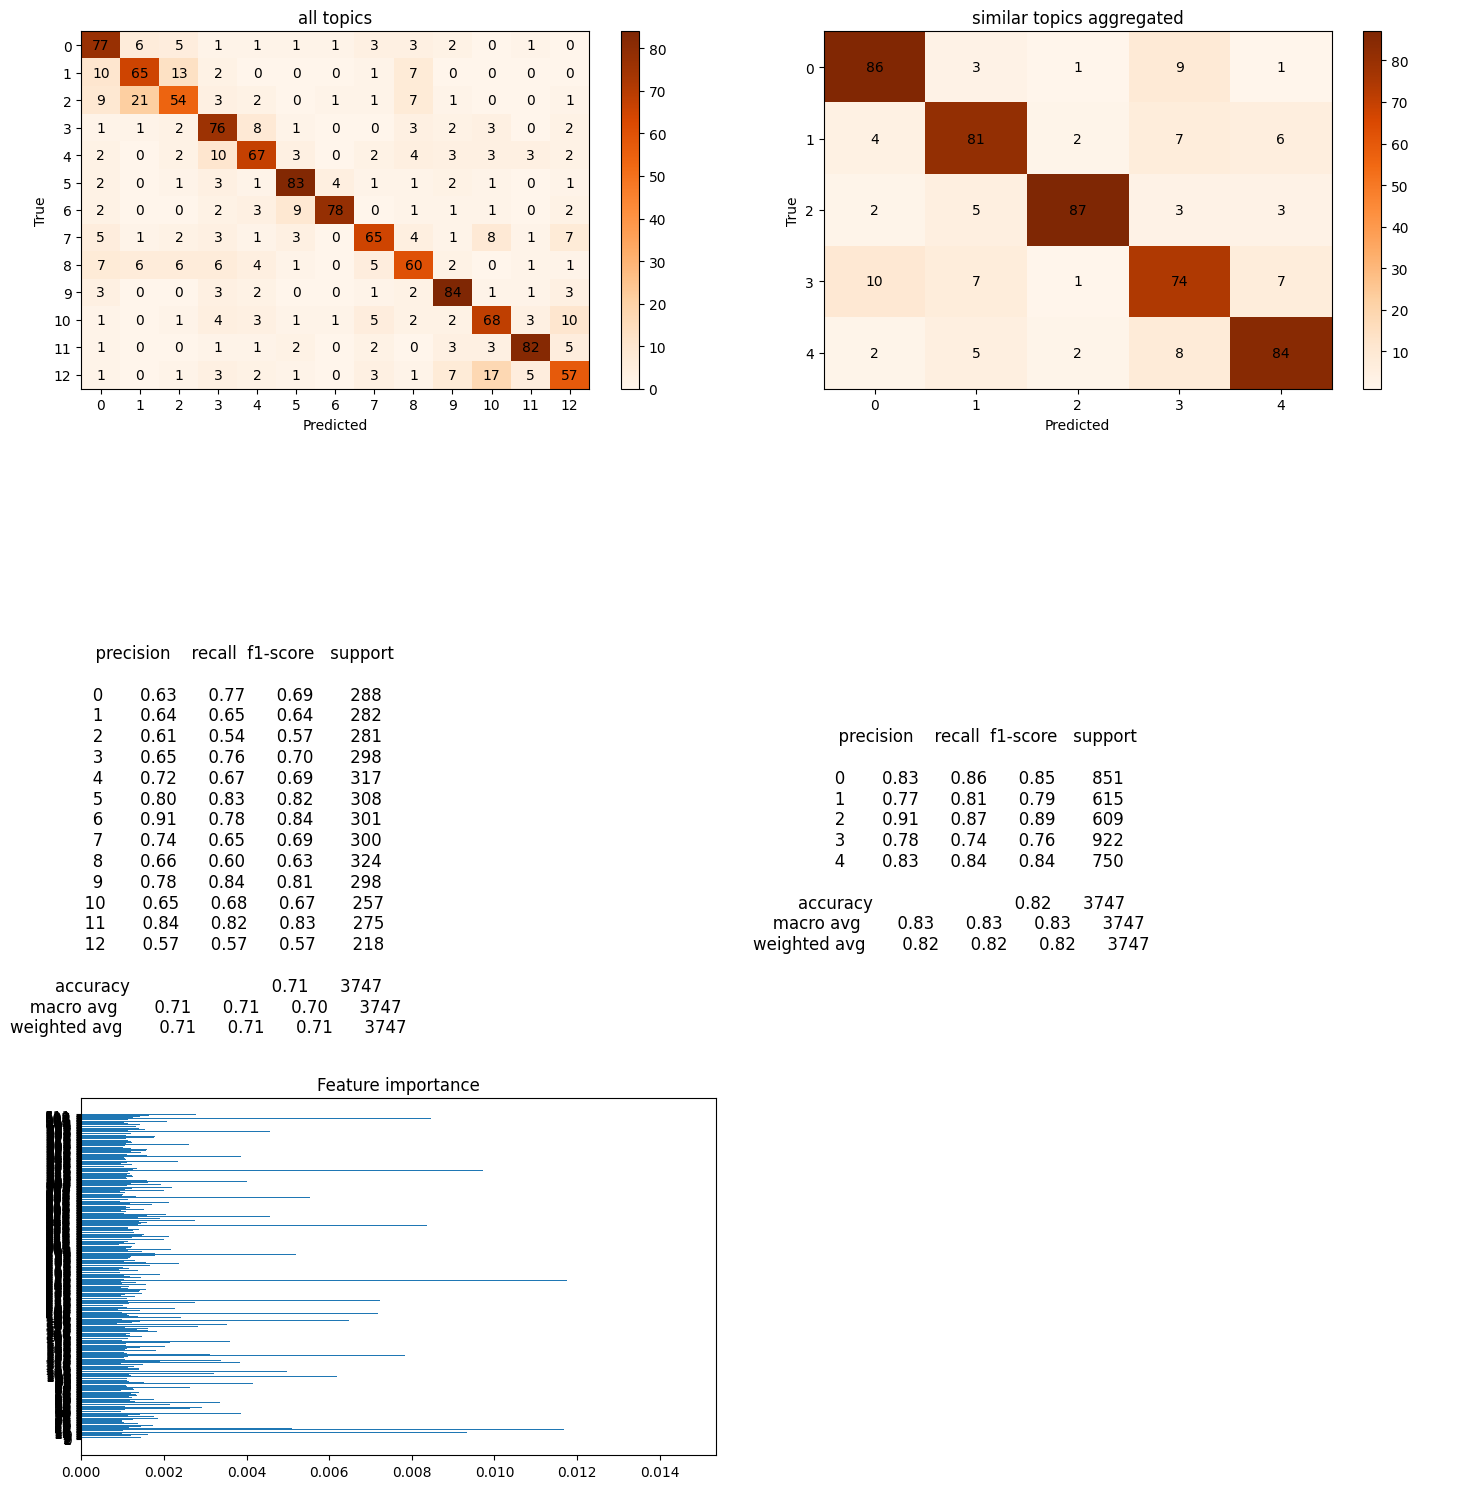

In [ ]:
evaluator(embeddings, topics, dict_related_categories = dict_related_categories, categories = None)

#USE explainabilty

In [ ]:
class_centroids = centroids_classes(np.array(embeddings), topics, categories = categories)
top_terms_per_topic = []
n_top_terms =10

for class_idx in range(0,len(categories)):
  centroid = np.array(class_centroids[class_idx])
  similarity_array = []

  for term in word_embeddings:
    similarity_array.append(cosine_similarity(centroid.reshape(1,-1), term.reshape(1,-1))) # *np.linalg.norm(term.reshape(1,-1)) **0.5 works

  similarity_array = np.array(similarity_array).reshape([len(similarity_array)])
  top_term_indices = similarity_array.argsort()[::-1][:n_top_terms] #indices tha would sort the array so you have the word with the max importance
  top_terms = [my_words[i] for i in top_term_indices]
  top_terms_per_topic.append(top_terms)

In [ ]:
for i in range(13):
    label = f'{label2id[i]} :'
    terms = top_terms_per_topic[i]
    print(f'{label.ljust(max_width)} {terms}')

comp.graphics :            ['quakers', 'bonjour', 'judgments', 'policeman', 'hospitalized', 'irled', 'hudson', 'leads', 'anatol', 'somalis']
comp.sys.ibm.pc.hardware : ['feudal', '486s', 'postema', '463', 'subjecting', 'policeman', 'epidemiologist', 'gasses', 'desparate', 'eduard']
comp.sys.mac.hardware :    ['feudal', 'subjecting', 'northeastern', 'postema', 'gasses', 'policeman', 'elder', 'eduard', 'transcript', 'maxtor']
rec.autos :                ['pity', 'grave', 'midnight_', 'stamp', 'abu', 'inflate', 'debating', '405', 'omer', 'imprint']
rec.motorcycles :          ['monuments', 'fart', 'virtual', 'step', 'etherfind', 'irretrievably', 'disapproved', 'albelin', 'hamilton', 'miata']
rec.sport.baseball :       ['clumsy', 'compulsory', 'nostrand', 'bikes', 'heavily', 'mechanisims', 'dvs', 'curling', 'karl', 'neighbouring']
rec.sport.hockey :         ['hack', 'coating', 'gozen', 'emi', 'commissioner', 'fledged', 'm13', 'lung', 'gxe', 'elg']
sci.crypt :                ['756', '780', '8

In [ ]:

[np.linalg.norm(term.reshape(1,-1)) for term in word_embeddings]
count = sum(1 for term in word_embeddings if 0.98 < np.linalg.norm(term.reshape(1, -1)) < 1.01)
count - len(word_embeddings)
len(word_embeddings[0])
stats.entropy(centroid, term)
cosine_similarity(np.array(class_centroids),np.array(class_centroids)).round(2)
len(similarity_array[similarity_array<0.95])

27601

In [ ]:
class_centroids = centroids_classes(np.array(embeddings), topics, categories = categories)
top_terms_per_topic = []
n_top_terms = 10

for class_idx in range(0,len(categories)):
  centroid = np.array(class_centroids[class_idx])
  similarity_array = []

  for term in word_embeddings:
    similarity_array.append(scipy.spatial.distance.cosine(centroid, term)) # *np.linalg.norm(term.reshape(1,-1)) **0.5 works

  similarity_array = np.array(similarity_array).reshape([len(similarity_array)])
  top_term_indices = similarity_array.argsort()[:n_top_terms] #indices tha would sort the array so you have the word with the max importance
  top_terms = [my_words[i] for i in top_term_indices]
  top_terms_per_topic.append(top_terms)

In [ ]:
for i in range(13):
    label = f'{label2id[i]} :'
    terms = top_terms_per_topic[i]
    print(f'{label.ljust(max_width)} {terms}')

comp.graphics :            ['quakers', 'bonjour', 'judgments', 'policeman', 'hospitalized', 'irled', 'hudson', 'leads', 'anatol', 'somalis']
comp.sys.ibm.pc.hardware : ['feudal', '486s', 'postema', '463', 'subjecting', 'policeman', 'epidemiologist', 'gasses', 'desparate', 'eduard']
comp.sys.mac.hardware :    ['feudal', 'subjecting', 'northeastern', 'postema', 'gasses', 'policeman', 'elder', 'eduard', 'transcript', 'maxtor']
rec.autos :                ['pity', 'grave', 'midnight_', 'stamp', 'abu', 'inflate', 'debating', '405', 'omer', 'imprint']
rec.motorcycles :          ['monuments', 'fart', 'virtual', 'step', 'etherfind', 'irretrievably', 'disapproved', 'albelin', 'hamilton', 'miata']
rec.sport.baseball :       ['clumsy', 'compulsory', 'nostrand', 'bikes', 'heavily', 'mechanisims', 'dvs', 'curling', 'karl', 'neighbouring']
rec.sport.hockey :         ['hack', 'coating', 'gozen', 'emi', 'commissioner', 'fledged', 'm13', 'lung', 'gxe', 'elg']
sci.crypt :                ['756', '780', '8

# Comparison with finetuning a Language model for classification

This part has the purpose to show the F1 score that is possible to obtain on this classification task fine-tunig distillBERT, with respect to the previous method there is no feature extraction (unless we extract the hidden state), and the process is supervised.
The previus methods can be used even in a semisuprevised or unsupervised setting.

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_size = 0.7
test_size = 0.15
val_size = 0.15

num_samples = len(documents)
num_train = int(train_size * num_samples)
num_test = int(test_size * num_samples)
num_val = num_samples - num_train - num_test

# Shuffle the data and split it
data = list(zip(documents, topics))
random.shuffle(data)

train_data = data[:num_train]
test_data = data[num_train:num_train + num_test]
val_data = data[num_train + num_test:]

# Create Dataset objects
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data, columns=["text", "label"]))
test_dataset = Dataset.from_pandas(pd.DataFrame(test_data, columns=["text", "label"]))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_data, columns=["text", "label"]))

# Create a DatasetDict
data_dict = DatasetDict({"train": train_dataset, "test": test_dataset, "val": val_dataset})

# documents topics
tokenized_docs = data_dict.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

Map:   0%|          | 0/8740 [00:00<?, ? examples/s]

Map:   0%|          | 0/1873 [00:00<?, ? examples/s]

Map:   0%|          | 0/1874 [00:00<?, ? examples/s]

In [ ]:
accuracy = evaluate.load("accuracy")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=13, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_docs['train']) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=13, id2label=id2label, label2id=label2id
)
tf_train_set = model.prepare_tf_dataset(
    tokenized_docs['train'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_docs['val'],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)
model.compile(optimizer=optimizer)
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
callbacks = [metric_callback]
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=callbacks)

Epoch 1/3
546/546 [==============================] - 584s 1s/step - loss: 1.2463 - val_loss: 0.7966 - accuracy: 0.7492
Epoch 2/3
546/546 [==============================] - 536s 982ms/step - loss: 0.6211 - val_loss: 0.7072 - accuracy: 0.7668
Epoch 3/3
546/546 [==============================] - 531s 972ms/step - loss: 0.4228 - val_loss: 0.6891 - accuracy: 0.7855


In [ ]:
# 1. Tokenize the test data
tokenized_test_data = tokenizer(
    tokenized_docs['test']['text'],  # Assuming 'text' contains the input text
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# 2. Create a TensorFlow dataset for inference
tf_test_set = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data)))

predictions = model.predict(tf_test_set)

predicted_labels = tf.argmax(predictions.logits, axis=1)

# If you want the predicted probabilities for each class, you can use the softmax function
predicted_probabilities = tf.nn.softmax(predictions.logits, axis=1)

1873/1873 [==============================] - 42s 22ms/step


In [ ]:
print(classification_report(tokenized_docs['test']['label'], predicted_labels))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       171
           1       0.75      0.69      0.72       156
           2       0.66      0.81      0.73       126
           3       0.62      0.81      0.70       145
           4       0.82      0.69      0.75       142
           5       0.97      0.82      0.89       142
           6       0.92      0.90      0.91       163
           7       0.75      0.85      0.79       132
           8       0.72      0.72      0.72       144
           9       0.93      0.87      0.90       160
          10       0.68      0.77      0.72       132
          11       0.90      0.86      0.88       147
          12       0.71      0.62      0.66       113

    accuracy                           0.79      1873
   macro avg       0.79      0.79      0.79      1873
weighted avg       0.80      0.79      0.79      1873



In [ ]:
print(classification_report([dict_related_categories[i] for i in tokenized_docs['test']['label']], [dict_related_categories[i] for i in predicted_labels.numpy()]))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       453
           1       0.78      0.84      0.81       287
           2       0.97      0.89      0.93       305
           3       0.85      0.86      0.85       436
           4       0.89      0.88      0.88       392

    accuracy                           0.88      1873
   macro avg       0.88      0.88      0.88      1873
weighted avg       0.88      0.88      0.88      1873



In [ ]:
cls_embeddings.shape

(1873, 13)

## classi

In [ ]:
tokenized_test_data = tokenizer(
    tokenized_docs['test']['text'],  # Assuming 'text' contains the input text
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Create a TensorFlow dataset for inference
tf_test_set = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data)))

# Perform inference and obtain the last hidden state
# Make sure to use the .predict() method on the model with the 'hidden_states' output
predictions = model.predict(tf_test_set)

# Extract the last hidden state from the model's output
last_hidden_state = predictions.hidden_states

# 'last_hidden_state' now contains the last hidden state for each input in 'tf_test_set'

# You can convert it to a NumPy array if needed
test_embeddings = last_hidden_state.numpy()

1873/1873 [==============================] - 40s 21ms/step


AttributeError: ignored

# Distil ber classification

In [5]:
! pip install transformers torch

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split

In [6]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories = categories,)
texts = newsgroups.data
labels = newsgroups.target
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_data = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

In [29]:
encoded_words = tokenizer(list(my_words.values()), padding=True, truncation=True, return_tensors='pt')

In [39]:
dataset = TensorDataset(encoded_data['input_ids'], encoded_data['attention_mask'], torch.tensor(labels))
word_data = TensorDataset(encoded_words['input_ids'], encoded_words['attention_mask'], torch.tensor(np.zeros(len(my_words))))

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=13)
train_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [9]:
for epoch in range(3):  # You can adjust the number of epochs
    model.train()

    # Use tqdm to create a progress bar for training
    train_data_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}, Training")

    for batch in train_data_iterator:
        input_ids, attention_mask, label = batch
        input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=label)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()

    # Use tqdm to create a progress bar for validation
    val_data_iterator = tqdm(val_dataloader, desc=f"Epoch {epoch + 1}, Validation")

    total_val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for batch in val_data_iterator:
            input_ids, attention_mask, label = batch
            input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=label)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()
            num_val_batches += 1

    avg_val_loss = total_val_loss / num_val_batches
    print(f"Epoch {epoch+1}, Average Validation Loss: {avg_val_loss}")

Epoch 1, Validation: 100%|██████████| 39/39 [00:22<00:00,  1.72it/s]


Epoch 1, Average Validation Loss: 1.5082161548810127


Epoch 2, Validation: 100%|██████████| 39/39 [00:22<00:00,  1.71it/s]


Epoch 2, Average Validation Loss: 1.0194447560188098


Epoch 3, Validation: 100%|██████████| 39/39 [00:22<00:00,  1.72it/s]

Epoch 3, Average Validation Loss: 0.9032103633269285


In [10]:
test_dataloader = DataLoader(test_dataset, batch_size=1)
model.eval()

predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids, attention_mask, _ = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        logits = model(input_ids, attention_mask=attention_mask).logits
        batch_predictions = torch.argmax(logits, dim=1).tolist()
        predictions.extend(np.array(batch_predictions))

100%|██████████| 2499/2499 [00:48<00:00, 51.81it/s]


In [12]:
print(len(predictions))
print(predictions[0])

2499
8


In [11]:
test_labels = []
for item in test_dataset:
    label = item[2].item()  # Assuming labels are stored at index 2
    test_labels.append(label)

cm = confusion_matrix(test_labels, predictions)
score = f1_score(test_labels, predictions, average = 'macro')
print(score)

0.8487777479748692


In [12]:
last_hidden_states = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        output = model.distilbert(input_ids, attention_mask=attention_mask)
        last_hidden_states.append(np.array(output.last_hidden_state[:,0,:].cpu()))

In [78]:
word_dataloader = DataLoader(word_data, batch_size=1)
word_hidden_states = []
with torch.no_grad():
    for batch in tqdm(word_dataloader):
        input_ids, attention_mask, _ = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        output = model.distilbert(input_ids, attention_mask=attention_mask)
        word_hidden_states.append(np.array(output.last_hidden_state[:,0,:].cpu())) # [:,1,:]

100%|██████████| 36498/36498 [05:28<00:00, 111.17it/s]


In [79]:
word_h_state = np.array(word_hidden_states)
word_h_state = word_h_state.reshape((len(my_words),768))

In [48]:
print(last_hidden_states[0].shape)
print(len(last_hidden_states))
test_h_state = np.array(last_hidden_states)
test_h_state = test_h_state.reshape((2499,768))
print(test_h_state.shape)

(1, 768)
2499
(2499, 768)


In [94]:
#import pickle
# Save the variables to a file
#with open('h_states.pkl', 'wb') as file:
#    pickle.dump((test_h_state,word_h_state, predictions, test_labels), file)

In [99]:
class_centroids = centroids_classes(np.array(test_h_state), test_labels, categories = categories)

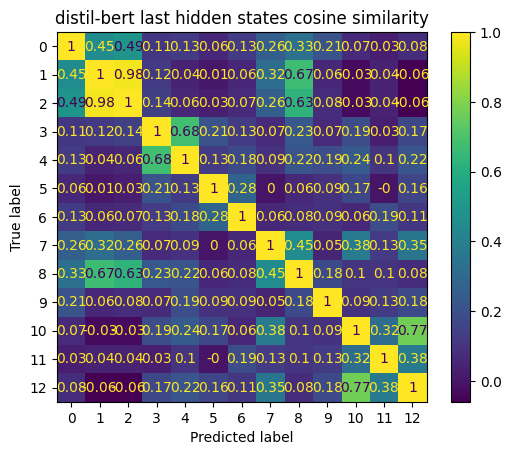

In [100]:
cs = cosine_similarity(np.array(class_centroids),np.array(class_centroids)).round(2)
disp = ConfusionMatrixDisplay(confusion_matrix=cs)
disp.plot()
plt.title('distil-bert last hidden states cosine similarity')
plt.show()

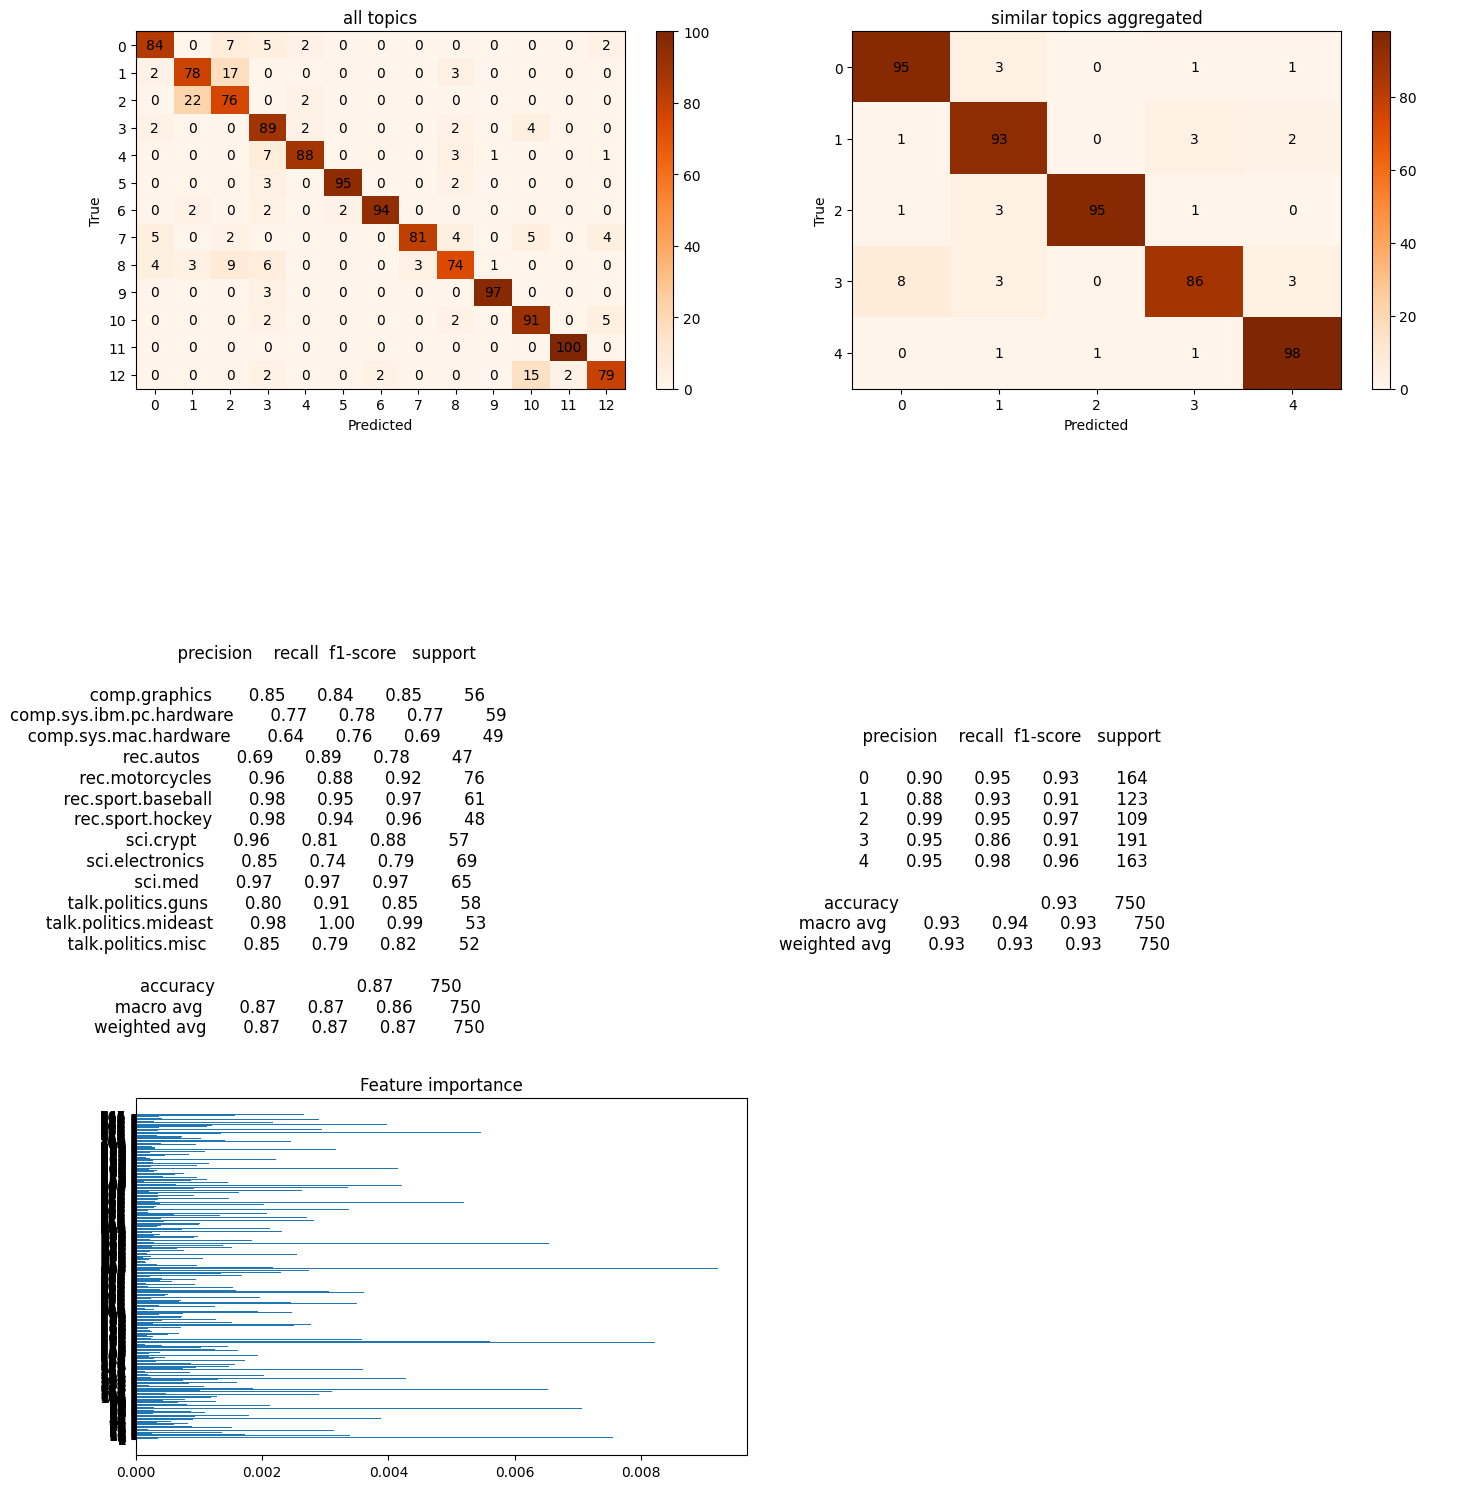

In [101]:
evaluator(test_h_state, test_labels, dict_related_categories, categories,)

In [102]:
top_terms_per_topic = []
n_top_terms = 10

for class_idx in tqdm(range(0,len(categories))):
  centroid = np.array(class_centroids[class_idx])
  similarity_array = []

  for term in word_h_state:
    similarity_array.append(scipy.spatial.distance.cosine(centroid, term)/(np.linalg.norm(term.reshape(1,-1))**2)) # /(np.linalg.norm(term.reshape(1,-1))**2) **0.5 works

  similarity_array = np.array(similarity_array).reshape([len(similarity_array)])
  top_term_indices = similarity_array.argsort()[:n_top_terms] #indices tha would sort the array so you have the word with the max importance
  top_terms = [my_words[i] for i in top_term_indices]
  top_terms_per_topic.append(top_terms)

100%|██████████| 13/13 [00:47<00:00,  3.69s/it]


In [103]:
for i in range(13):
    label = f'{label2id[i]} :'
    terms = top_terms_per_topic[i]
    print(f'{label.ljust(max_width)} {terms}')

comp.graphics :            ['hospitalized', 'puck', 'italians', 'v1', 'journalism', 'jitter', 'jaw', 'khan', 'pseudonymity', 'v8s']
comp.sys.ibm.pc.hardware : ['06066', 'ouch', 'anarchists', 'honorable', 'stubble', 'igor_larionov', 'indecent', 'lenarduzzi', 'x9', 'rapacity']
comp.sys.mac.hardware :    ['leaking', 'wimsey', '06066', 'talons', 'trades', 'anarchists', 'tan', 'fishes', 'pkp', 'ouch']
rec.autos :                ['7140', '664', 'bayur', '6674', 'mif', 'elitist', 'subset', 'pcx', 'revolutionaries', 'sequential']
rec.motorcycles :          ['5500', 'application', 'soldier', 'oto', 'marine', 'premiere', 'tamara', 'mfm', 'guard', 'mcats']
rec.sport.baseball :       ['1995', 'neighbours', '91109', '4440', '45', '916', 'fatalities', 'tenth', 'senses', '1kspt']
rec.sport.hockey :         ['garaged', 'myopia', 'bli', 'strategies', 'setver', 'msg', 'frost', 'contries', 'commissioner', 'fp1']
sci.crypt :                ['foreign', '32w', 'complies', 'diplomats', '773', 'poisonous', '8

# Lbl2Vec

Lbl2Vec is an algorithm for unsupervised document classification and unsupervised document retrieval. It automatically generates jointly embedded label, document and word vectors and returns documents of topics modeled by manually predefined keywords. This package includes two different model types. The plain Lbl2Vec model uses Doc2Vec, and Lbl2TransformerVec uses transformer-based language models to create the embeddings.



1.   Keywords are manually defined for each topic
2.   Create jointly embedded document and word vectors using Doc2Vec (or sentence transformers)
3.  Find document vectors that are similar to the keyword vectors of each topic.
4. Clean outlier document vectors for each topic
5. Compute centroids
6.  Compute label vector <-> document vector similarities for each label vector and document vector in the dataset.



In [ ]:
# for each label we need keywords
x_train, x_val, label_train, label_val = train_test_split(documents, topics, test_size=0.3, random_state=random_state)
categories = [
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",

    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",

]
label_id = list(range(len(categories)))
keyword = [['graphics','ram'],
           ['pc','ibm'],
           ['mac'],
           ['autos', 'car'],
           ['motorcycles', 'bike', 'motor'],
           ['baseball'],
           ['hockey'],
           ['encryption', 'privacy'],
           ['electronics','phone'],
           ['medicine', 'treatment', 'disease'],
           ['guns', 'own', 'freedom', ],
           ['israeli', 'jews', 'arab', 'palestinian'],
           ['politics', 'government', 'armenian', 'russian', 'genocide'],
          ]
label_df = pd.DataFrame()
label_df['class_index'] = label_id
label_df['class_name'] = categories
label_df['keywords'] = keyword
label_df['number_of_keywords'] = label_df['keywords'].map(len)
print(label_df)
newsgroup_train = pd.DataFrame(np.array([x_train, [int(l) for l in label_train]]).T.tolist() , columns = ['text', 'class_index'])
newsgroup_test = pd.DataFrame(np.array([x_val, [int(l) for l in label_val]]).T.tolist(), columns = ['text', 'class_index'])
newsgroup_train['class_index'] = newsgroup_train['class_index'].astype('int')
newsgroup_test['class_index']  =newsgroup_test['class_index'].astype('int')

    class_index                class_name  \
0             0             comp.graphics   
1             1  comp.sys.ibm.pc.hardware   
2             2     comp.sys.mac.hardware   
3             3                 rec.autos   
4             4           rec.motorcycles   
5             5        rec.sport.baseball   
6             6          rec.sport.hockey   
7             7                 sci.crypt   
8             8           sci.electronics   
9             9                   sci.med   
10           10        talk.politics.guns   
11           11     talk.politics.mideast   
12           12        talk.politics.misc   

                                             keywords  number_of_keywords  
0                                     [graphics, ram]                   2  
1                                           [pc, ibm]                   2  
2                                               [mac]                   1  
3                                        [autos, car]            

In [ ]:
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)

# add data set type column
newsgroup_train['data_set_type'] = 'train'
newsgroup_test['data_set_type'] = 'test'

# concat train and test data
newsgroup_full_corpus = pd.concat([newsgroup_train,newsgroup_test]).reset_index(drop=True)

# reduce dataset to only articles that belong to classes where we defined our keywords
newsgroup_full_corpus = newsgroup_full_corpus[newsgroup_full_corpus['class_index'].isin(list(label_df['class_index']))]

# tokenize and tag documents for Lbl2Vec training
newsgroup_full_corpus['tagged_docs'] = newsgroup_full_corpus.apply(lambda row: TaggedDocument(tokenize(row['text']), [str(row.name)]), axis=1)

# add doc_key column
newsgroup_full_corpus['doc_key'] = newsgroup_full_corpus.index.astype(str)

# add class_name column
newsgroup_full_corpus = newsgroup_full_corpus.merge(label_df, left_on='class_index', right_on='class_index', how='left')

newsgroup_full_corpus.head()

,text,class_index,data_set_type,tagged_docs,doc_key,class_name,keywords,number_of_keywords
0,\n\nUtah raster toolkit using getx11. Convert ...,0,train,"([utah, raster, toolkit, using, getx, convert,...",0,comp.graphics,"[graphics, ram]",2
1,\nWhat's despicable is that this sordid incide...,12,train,"([what, despicable, is, that, this, sordid, in...",1,talk.politics.misc,"[politics, government, armenian, russian, geno...",5
2,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,9,train,"([dn, from, nyeda, cnsvax, uwec, edu, david, n...",2,sci.med,"[medicine, treatment, disease]",3
3,\n\n\n\n Alomar fans left RBI fans and Runs o...,5,train,"([alomar, fans, left, rbi, fans, and, runs, of...",3,rec.sport.baseball,[baseball],1
4,We have a user that has Word 5.0 and is using ...,2,train,"([we, have, user, that, has, word, and, is, us...",4,comp.sys.mac.hardware,[mac],1


In [ ]:
# doc2vec_model = Doc2Vec(documents=newsgroup_full_corpus['tagged_docs'][newsgroup_full_corpus['data_set_type']=='train'], dbow_words=1, dm=0)
# Lbl2Vec_model = Lbl2Vec(keywords_list=list(label_df.keywords),doc2vec_model=doc2vec_model, similarity_threshold=0.43, label_names=list(label_df.class_name), epochs=10)
# if not Doc2Vec use the tagged document
Lbl2Vec_model = Lbl2Vec(keywords_list=list(label_df.keywords),tagged_documents=newsgroup_full_corpus['tagged_docs'][newsgroup_full_corpus['data_set_type'] == 'train'], similarity_threshold=0.43, label_names=list(label_df.class_name), epochs=10)
Lbl2Vec_model.fit()

2023-10-02 16:54:33,952 - Lbl2Vec - INFO - Train document and word embeddings
INFO:Lbl2Vec:Train document and word embeddings
2023-10-02 16:56:20,027 - Lbl2Vec - INFO - Train label embeddings
INFO:Lbl2Vec:Train label embeddings


In [ ]:
from sklearn.metrics import f1_score

# predict similarity scores
model_docs_lbl_similarities = Lbl2Vec_model.predict_model_docs()

# merge DataFrames to compare the predicted and true category labels
evaluation_train = model_docs_lbl_similarities.merge(newsgroup_full_corpus[newsgroup_full_corpus['data_set_type'] == 'train'], left_on='doc_key', right_on='doc_key')
y_true_train = evaluation_train['class_name']
y_pred_train = evaluation_train['most_similar_label']

print('F1 score:',f1_score(y_true_train, y_pred_train, average='micro'))
print(confusion_matrix(y_true_train, y_pred_train))

2023-10-02 16:56:20,455 - Lbl2Vec - INFO - Get document embeddings from model
INFO:Lbl2Vec:Get document embeddings from model
2023-10-02 16:56:20,489 - Lbl2Vec - INFO - Calculate document<->label similarities
INFO:Lbl2Vec:Calculate document<->label similarities


F1 score: 0.5149885583524028
[[354  34  38   3  18   7  16  11 133  17  42   4   8]
 [ 96 241 174   1  13   4   5   4 143   5  11   2   1]
 [100  74 278   3  16   2   4   6 158   8  25   3   5]
 [ 10   9   7 184 242  12  12   9  78  13 105   6   5]
 [  5   1   4  29 419  13  18   8  46  15 111   1   9]
 [  4   2   3   5  25 418 123   5  13   6  68   7   7]
 [  2   0   1   4  11  77 542   6  10   5  38   0   2]
 [ 12  12   1   1   5   5   1 404  67   9 154   4  16]
 [ 31  55  23  16  64   3  13  17 373  27  31   2   5]
 [  4   3   1   2  61   9  12   7  51 448  81   5   8]
 [  1   1   4  11  26   6   9   7  14   9 525   9  31]
 [  3   1   5   1   8  10   9   7  10   7 126 268 210]
 [  4   1   2   5  14  10  21   4  11  48 371  19  47]]


In [ ]:
print(confusion_matrix(y_true_train, y_pred_train, normalize='true').round(1))

[[0.5 0.  0.1 0.  0.  0.  0.  0.  0.2 0.  0.1 0.  0. ]
 [0.1 0.3 0.2 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0. ]
 [0.1 0.1 0.4 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0. ]
 [0.  0.  0.  0.3 0.3 0.  0.  0.  0.1 0.  0.2 0.  0. ]
 [0.  0.  0.  0.  0.6 0.  0.  0.  0.1 0.  0.2 0.  0. ]
 [0.  0.  0.  0.  0.  0.6 0.2 0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.8 0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.6 0.1 0.  0.2 0.  0. ]
 [0.  0.1 0.  0.  0.1 0.  0.  0.  0.6 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0.  0.1 0.6 0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.4 0.3]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.7 0.  0.1]]


In [ ]:
new_docs_lbl_similarities = Lbl2Vec_model.predict_new_docs(tagged_docs=newsgroup_full_corpus['tagged_docs'][newsgroup_full_corpus['data_set_type']=='test'])

# merge DataFrames to compare the predicted and true topic labels
evaluation_test = new_docs_lbl_similarities.merge(newsgroup_full_corpus[newsgroup_full_corpus['data_set_type']=='test'], left_on='doc_key', right_on='doc_key')
y_true_test = evaluation_test['class_name']
y_pred_test = evaluation_test['most_similar_label']

print('F1 score:',f1_score(y_true_test, y_pred_test, average='micro'))

2023-10-02 16:56:58,518 - Lbl2Vec - INFO - Calculate document embeddings
INFO:Lbl2Vec:Calculate document embeddings
2023-10-02 16:57:02,975 - Lbl2Vec - INFO - Calculate document<->label similarities
INFO:Lbl2Vec:Calculate document<->label similarities


F1 score: 0.5340272217774219


In [ ]:
y_true_test = [dict_related_categories_name[i] for i in evaluation_test['class_name'] ]
y_pred_test = [dict_related_categories_name[i] for i in evaluation_test['most_similar_label'] ]

print('F1 score:',f1_score(y_true_test, y_pred_test, average='macro'))

F1 score: 0.7568249610942728


In [ ]:
s = newsgroup_full_corpus[newsgroup_full_corpus['class_index']==2]['text']

In [ ]:
s[s.index[53
         ]]

'Hi all:\nDoes anyone know where I can get the cheapest price for\nthe Teleport Gold fax modem by Global Village?\nAny answer will be highly appreciated.\nThanks in advance.\n\nRegards,'

# Conclusion


Model          |F1 13 classes | F1 5 classes | embedding size
-------------------|--------------|----|---
LSA                  | 0.59 | 0.79 | 13
LSA                  | 0.66 | 0.80 | 25
LDA                  | 0.50 | 0.74 | 13
NMF                  | 0.54 | 0.78 | 13
USE                  | 0.71 | 0.83 | 512
Lbl2Vec              | 0.54 | 0.76 |
distil-BER fine-tuned      | 0.79 | 0.89 |


The methods based on matrix factorization and probability estimation ( LSA, LDA, NMF ) have a quality of features/embedding similar to the one obtained trough a large pretrained Neural network like USE. All of the mentioned method reach this quality of features without using the labels.

Using distil-BERT for classification after finetuning achieves way better perfomances, but using its last Hidden state as sentence representation it is not useful (at least if we don't want to use label to fine-tune the model).

**NOTE :** The methods mentioned can be used for the classification even without the label in fact once the embedding are obtained it is possible to cluster them, or compute similarity as it is done directly from Lbl2Vec.

